# F1tenth

In [2]:
import gym
import numpy as np



## Environment playground

In [5]:
# racecar_env = gym.make(
#     'f110_gym:f110-v0',
#     map='./f1tenth_gym/gym/f110_gym/envs/maps/vegas',
#     map_ext='.png'
# )

racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png'
)

In [4]:
obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 0.], # pose of ego
             [2., 0., 0.]])  # pose of 2nd agent
) 

obs

{'ego_idx': 0,
 'scans': [array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365]),
  array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365])],
 'poses_x': [0.0, 2.0],
 'poses_y': [0.0, 0.0],
 'poses_theta': [0.0, 0.0],
 'linear_vels_x': [0.0, 0.0],
 'linear_vels_y': [0.0, 0.0],
 'ang_vels_z': [0.0, 0.0],
 'collisions': array([0., 0.]),
 'lap_times': array([0.01, 0.01]),
 'lap_counts': array([0., 0.])}

In [5]:
state = np.concatenate([
    obs['scans'][0],
    np.array(obs['linear_vels_x'][:1]),
    np.array(obs['linear_vels_y'][:1]),
])
state.shape

(1082,)

In [6]:
speeds = np.random.rand(2, 1)*2
pi_4 = 3.1415/8
pi_2 = 3.1415/4
angles = np.random.rand(2, 1)*pi_2-pi_4
actions = np.concatenate([angles, speeds], axis=1)

actions

array([[-0.0596855 ,  0.44670051],
       [-0.05675966,  1.8354974 ]])

In [2]:
## action consists of ndarray(num_agent, 2) 0: steering angle 1: velocity
## the reward function is only for the first agent

import time
import gym 
import numpy as np


racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png',
    num_agents=1
)
steps = 0

obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 1.5]]) 
) 

rewards = []

while not done:
    
    speeds = np.random.rand(2, 1)*20
    pi_4 = 3.1415/8
    pi_2 = 3.1415/4
    speeds[1][0] = 0.1
    angles = np.random.rand(2, 1)*pi_2-pi_4
    actions = np.concatenate([angles, speeds], axis=1)

    obs, step_reward, done, info = racecar_env.step(actions)
    rewards.append(step_reward)
    
    racecar_env.render()
    steps += 1
    
    if steps > 500:
        break

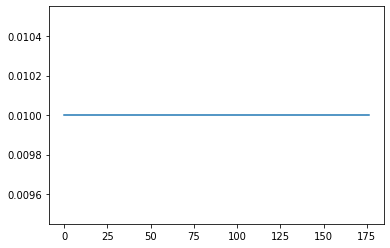

In [16]:
import matplotlib.pyplot as plt

plt.plot(rewards)

## Define environment wrapper

### waypoints

In [ ]:
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

from numba import njit

from pyglet.gl import GL_POINTS


# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t

# @njit(fastmath=False, cache=True)
def get_actuation(pose_theta, lookahead_point, position, lookahead_distance, wheelbase):
    """
    Returns actuation
    """
    waypoint_y = np.dot(np.array([np.sin(-pose_theta), np.cos(-pose_theta)]), lookahead_point[0:2]-position)
    speed = lookahead_point[2]
    if np.abs(waypoint_y) < 1e-6:
        return speed, 0.
    radius = 1/(2.0*waypoint_y/lookahead_distance**2)
    steering_angle = np.arctan(wheelbase/radius)
    return speed, steering_angle

class PurePursuitPlanner:
    """
    Example Planner
    """
    def __init__(self, conf, wb):
        self.wheelbase = wb
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        self.drawn_waypoints = []

    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

    def render_waypoints(self, e):
        """
        update waypoints being drawn by EnvRenderer
        """

        #points = self.waypoints

        points = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        
        scaled_points = 50.*points

        for i in range(points.shape[0]):
            if len(self.drawn_waypoints) < points.shape[0]:
                b = e.batch.add(1, GL_POINTS, None, ('v3f/stream', [scaled_points[i, 0], scaled_points[i, 1], 0.]),
                                ('c3B/stream', [183, 193, 222]))
                self.drawn_waypoints.append(b)
            else:
                self.drawn_waypoints[i].vertices = [scaled_points[i, 0], scaled_points[i, 1], 0.]
        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None

    def plan(self, pose_x, pose_y, pose_theta, lookahead_distance, vgain):
        """
        gives actuation given observation
        """
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, lookahead_distance, position, pose_theta)

        if lookahead_point is None:
            return 4.0, 0.0

        speed, steering_angle = get_actuation(pose_theta, lookahead_point, position, lookahead_distance, self.wheelbase)
        speed = vgain * speed

        return speed, steering_angle

def main():
    """
    main entry point
    """

    work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}
    
    with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
        conf_dict = yaml.load(file, Loader=yaml.FullLoader)
    conf = Namespace(**conf_dict)

    planner = PurePursuitPlanner(conf, 0.17145+0.15875)

    def render_callback(env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

        planner.render_waypoints(env_renderer)

    env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
    env.add_render_callback(render_callback)
    
    obs, step_reward, done, info = env.reset(np.array([[conf.sx, conf.sy, conf.stheta]]))
    env.render()

    laptime = 0.0
    start = time.time()

    while not done:
        speed, steer = planner.plan(obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0], work['tlad'], work['vgain'])
        obs, step_reward, done, info = env.step(np.array([[steer, speed]]))
        laptime += step_reward
        env.render(mode='human')
        
    print('Sim elapsed time:', laptime, 'Real elapsed time:', time.time()-start)

main()

### waypoint handler

In [3]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace



# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t
    
    
CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)

        
        work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None
    
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):
        

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(action)
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, 1.8, position, 0.9033)
        
        print(position, lookahead_point)
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        

        next_state = self.to_vector_state(obs)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()



### checkpoint handler

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs][3:]
        self.t = 0
        
        
        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.next_cp_idx = 0
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        buck = 3
        scanner = np.zeros(1080//buck,)
        for i in range(1080//buck):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        scanner /= 10
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'])/5,
            np.array(obs['ang_vels_z'])
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
#             print(f"Got to CP {self.next_cp_idx}")
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        angle = action[0]*(np.pi/4)
#         action[1] = action[1]*5
        speed = 5
        act = np.array([[angle, speed]])
#         action = np.repeat(action, repeats=2, axis=0)
#         action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
#         print(action, position)
        
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -1
            
        if int(self.t+1) % 100 == 0:
            print(self.t+1, position, action[0], angle)
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

## Env simple wrapper

In [9]:

CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)
        
        self.env = gym.make(
            'f110_gym:f110-v0',
            map='./f1tenth_gym/examples/example_map',
            map_ext='.png'
        )
        
        self.reset()
        self.prev_capture_coord = None
        
    def reset(self):
        obs, step_reward, done, info = self.env.reset(
            poses=np.array([[0., 0., 0.], 
                     [-1., -1., 0.]]) 
        )
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        obs, step_reward, done, info = self.env.step(action)
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        
        moving_forward_rew = 0

        if self.time_to_capture == 0:
            current_coord = [obs['poses_x'][0], obs['poses_y'][0]]
            dist = abs(current_coord[0] - self.prev_capture_coord[0]) + abs(current_coord[1] - self.prev_capture_coord[1])
            # print(f"prev coord:{self.prev_capture_coord}, current_coord:{current_coord}, dist:{dist}")
            
            self.prev_capture_coord = current_coord
            if dist < 2:
                # print("Neg reward")
                moving_forward_rew = -10

            self.time_to_capture = CAPTURE_TIME + 1

        next_state = self.to_vector_state(obs)
        # ang_vel = obs['ang_vels_z'][0]
        # print(obs['ang_vels_z'][0]*0.1)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()


## Render

In [ ]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = np.array([1.0, 0.0])
    obs, reward, done, _ = env.step(action)
    env.render()

# RAY algorithms

## ppo continuous actions

In [2]:
import ray
from ray.rllib.agents import ppo, sac, ddpg

In [ ]:

gpu_configs = {
    "num_workers": 1,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [1024, 512, 128],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "render_env": False,
    },
    "num_gpus": 2
}


config = {
    "num_workers": 1,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [512, 512, 128],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "render_env": False,
    },
}

ppo_config = {
    # Should use a critic as a baseline (otherwise don't use value baseline;
    # required for using GAE).
    "use_critic": True,
    # If true, use the Generalized Advantage Estimator (GAE)
    # with a value function, see https://arxiv.org/pdf/1506.02438.pdf.
    "use_gae": True,
    # The GAE (lambda) parameter.
    "lambda": 1.0,
    # Initial coefficient for KL divergence.
    "kl_coeff": 0.2,
    # Size of batches collected from each worker.
    "rollout_fragment_length": 200,
    # Number of timesteps collected for each SGD round. This defines the size
    # of each SGD epoch.
    "train_batch_size": 4000,
    # Total SGD batch size across all devices for SGD. This defines the
    # minibatch size within each epoch.
    "sgd_minibatch_size": 128,
    # Whether to shuffle sequences in the batch when training (recommended).
    "shuffle_sequences": True,
    # Number of SGD iterations in each outer loop (i.e., number of epochs to
    # execute per train batch).
    "num_sgd_iter": 30,
    # Stepsize of SGD.
    "lr": 5e-4,
    # Learning rate schedule.
    "lr_schedule": None,
    # Coefficient of the value function loss. IMPORTANT: you must tune this if
    # you set vf_share_layers=True inside your model's config.
    "vf_loss_coeff": 1.0,
    "model": {
        # Share layers for value function. If you set this to True, it's
        # important to tune vf_loss_coeff.
        "vf_share_layers": False,
    },
    # Coefficient of the entropy regularizer.
    "entropy_coeff": 0.0,
    # Decay schedule for the entropy regularizer.
    "entropy_coeff_schedule": None,
    # PPO clip parameter.
    "clip_param": 0.3,
    # Clip param for the value function. Note that this is sensitive to the
    # scale of the rewards. If your expected V is large, increase this.
    "vf_clip_param": 10.0,
    # If specified, clip the global norm of gradients by this amount.
    "grad_clip": None,
    # Target value for KL divergence.
    "kl_target": 0.01,
    # Whether to rollout "complete_episodes" or "truncate_episodes".
    "batch_mode": "truncate_episodes",
    # Which observation filter to apply to the observation.
    "observation_filter": "NoFilter",

    "num_workers": 10,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [300, 300],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 20,
    "evaluation_config": {
        "render_env": False,
    },
    "num_gpus": 2
}


ray.shutdown()
ray.init()
trainer = ppo.PPOTrainer(env=F110Env, config=ppo_config)
# trainer = sac.SACTrainer(env=F110Env, config=sac_configs)
# trainer = ddpg.DDPGTrainer(env=F110Env, config=ddpg_configs)
rewards = []

for i in range(10000):

    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%10 == 0:
        cp = trainer.save("./ppo_cp_3")
        print("checkpoint saved at", cp)


2022-02-18 18:46:46,087	WARNING trainer.py:2279 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-02-18 18:46:46,088	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-18 18:46:46,088	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=36364) 2022-02-18 18:46:52,740	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=36365) 2022-02-18 18:46:52,948	WARNI

(RolloutWorker pid=36358) 100 [0.82692213 3.33832862] -0.6478256 -0.5088010354339767
(RolloutWorker pid=36364) 100 [0.96269764 3.30367524] -0.37200022 -0.29216828755905566
(RolloutWorker pid=36361) 100 [0.13294276 3.43669294] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 100 [-0.98422658  3.10520554] 0.38512087 0.30247322294954915
(RolloutWorker pid=36351) 100 [0.88047596 3.30755572] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 100 [-0.62471201  3.29696127] -0.14022529 -0.11013268621130007
(RolloutWorker pid=36352) 100 [0.86501242 3.3155151 ] 0.4785521 0.37585394281964646
(RolloutWorker pid=36322) 100 [0.82242453 3.35006981] -0.2691958 -0.2114258830338148
(RolloutWorker pid=36362) 100 [0.81684849 3.35043228] 0.75118923 0.5899826430766474
(RolloutWorker pid=36323) 100 [-0.33562271  3.41826207] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 200 [-0.53266677  8.33935856] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 100 [-0.36469571  3.39371994] 0.7970382 0.6259923364877746


(RolloutWorker pid=36346) 2022-02-18 18:47:04,926	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
2022-02-18 18:47:14,820	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:-0.5185185185185185
checkpoint saved at ./ppo_cp_3/checkpoint_000001/checkpoint-1
(RolloutWorker pid=36358) 100 [0.44458246 3.36973067] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 100 [-0.04669755  3.43829852] 0.47260177 0.37118056324034276
(RolloutWorker pid=36352) 100 [-1.18962989  2.96799822] 0.1228838 0.0965127082331194
(RolloutWorker pid=36322) 100 [0.05356003 3.42531708] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 100 [-0.59691119  3.30869678] -0.34982145 -0.2747491230323628
(RolloutWorker pid=36323) 100 [0.3319065  3.41474198] -0.45647407 -0.3585138929026804
(RolloutWorker pid=36361) 100 [-0.75606462  3.1944743 ] -0.5167694 -0.405869744869711
(RolloutWorker pid=36358) 100 [-0.06693755  3.35446759] -0.97085094 -0.7625045487579343
(RolloutWorker pid=36351) 100 [-0.27905768  3.37986821] -0.7760349 -0.6094963785992011
(RolloutWorker pid=36363) 100 [-0.45126245  3.3843075 ] -0.030235171 -0.023746648023206973
(RolloutWorker pid=36364) 100 [-0.82103642  3.

(RolloutWorker pid=36322) 600 [-20.82184543  13.72441969] 0.008695602 0.006829510167940076
(RolloutWorker pid=36365) 600 [-20.55733683  13.72059228] 0.9420979 0.7399219622054172
(RolloutWorker pid=36352) 700 [-25.07508675  15.63707381] 0.96427846 0.7573425311334661
(RolloutWorker pid=36358) 500 [ 0.68783925 -2.08949344] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 200 [-1.91388862  7.9507136 ] 0.75740373 0.5948634995496251
(RolloutWorker pid=36361) 800 [-28.24587191  18.15947662] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 100 [-0.85028818  3.31564246] -0.07470441 -0.058672705347970165
(RolloutWorker pid=36363) 100 [-0.19591205  3.42554388] -0.22680807 -0.17813464251430497
(RolloutWorker pid=36365) 700 [-24.94762687  16.06435121] -0.7266859 -0.5707377567870292
(RolloutWorker pid=36352) 800 [-29.08260265  18.59821062] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 700 [-25.28448329  15.92636347] -0.26781452 -0.21034102979960878
(RolloutWorker pid=36362) 100 [0.0846882  3.41

(RolloutWorker pid=36323) 200 [-2.08278491  7.8807161 ] -0.5702506 -0.44787375096230775
(RolloutWorker pid=36322) 1500 [-43.75019592   9.42195289] 0.48227143 0.37877509764032713
(RolloutWorker pid=36362) 900 [-32.57180869  21.41955177] 0.8154404 0.6404454053503917
(RolloutWorker pid=36365) 1500 [-42.88707292  11.02392784] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 100 [-0.24732324  3.43292579] 0.80132675 0.6293605590734794
(RolloutWorker pid=36358) 700 [-25.13847349  16.34239652] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 900 [-33.21628675  21.86988358] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 500 [-16.45791339  12.51458518] 0.6806067 0.5345472701079937
(RolloutWorker pid=36363) 800 [-29.3436194   19.13855469] 0.041974902 0.03296701105976568
(RolloutWorker pid=36351) 100 [-0.27283004  3.42571295] -0.3782066 -0.29704277741255236
(RolloutWorker pid=36323) 300 [-6.79110631  9.48785918] -0.8420027 -0.661307366174798
episode: 5 reward:2.051948051948052
(RolloutWorker pid

(RolloutWorker pid=36363) 1600 [-49.0101694    6.86201805] -0.8651128 -0.6794579897411245
(RolloutWorker pid=36322) 800 [-28.64944729  18.31108477] -0.14199924 -0.11152594598330484
(RolloutWorker pid=36362) 200 [-1.67607945  8.1206599 ] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 300 [-6.43866782  9.78649092] 0.6118791 0.48056872947939755
(RolloutWorker pid=36323) 1100 [-40.43978728  26.57063136] 1.0 0.7853981633974483
episode: 7 reward:3.2857142857142856
(RolloutWorker pid=36361) 1000 [-36.36436108  24.47112628] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 300 [-6.68148574  9.38590215] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 1400 [-46.92699988  15.83446446] -0.8569656 -0.6730592094690991
(RolloutWorker pid=36322) 900 [-32.84681737  20.50989793] -0.079580426 -0.06250232059253111
(RolloutWorker pid=36362) 300 [-6.30311142  9.83768983] -0.20328933 -0.15966306642473194
(RolloutWorker pid=36365) 100 [-0.33575726  3.41365674] 1.0 0.7853981633974483
(RolloutWorker pid=36363

(RolloutWorker pid=36352) 600 [-20.19751372  13.4089064 ] -1.0 -0.7853981633974483
episode: 9 reward:4.52808988764045
(RolloutWorker pid=36351) 300 [-6.36202574  9.54402847] -0.20862472 -0.16385347237767406
(RolloutWorker pid=36364) 1100 [-41.93167354  25.37911225] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 800 [-29.2100441   18.79349349] -0.2511298 -0.19723688843952236
(RolloutWorker pid=36362) 1100 [-41.07132971  25.455745  ] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 2500 [-28.51135825  -3.46670506] -0.74798214 -0.5874638024311098
(RolloutWorker pid=36322) 300 [-6.97554691  9.4715835 ] 0.26800156 0.21048793018145648
(RolloutWorker pid=36358) 900 [-32.70233454  21.52495453] 0.8313539 0.6529438284055938
(RolloutWorker pid=36361) 300 [-6.40787377  8.59829771] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 700 [-24.53159307  15.894519  ] 0.3256421 0.25575871426846924
(RolloutWorker pid=36364) 1200 [-46.23945706  22.93938152] 0.096170306 0.07553198186736589
(RolloutWork

(RolloutWorker pid=36323) 100 [-0.27208985  3.42776618] -0.3394487 -0.2666023780191613
(RolloutWorker pid=36322) 400 [-11.39558678  10.39660152] -0.6493794 -0.5100213665856674
(RolloutWorker pid=36362) 200 [-2.53490947  7.66049214] 0.64522994 0.506762406425467
(RolloutWorker pid=36352) 100 [-0.35362031  3.41199604] 0.1708107 0.1341544096467878
(RolloutWorker pid=36358) 1800 [-51.12612672  -0.96082617] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 900 [-32.19799088  21.62078512] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 300 [-6.42413886  9.35850515] 0.455158 0.3574802535045934
(RolloutWorker pid=36364) 300 [-6.20886965  9.44748426] -0.78437 -0.6160427614537521
(RolloutWorker pid=36365) 700 [-25.34694858  16.03948442] 0.7037101 0.5526926037625456
(RolloutWorker pid=36323) 200 [-1.61006851  7.9835282 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 900 [-33.50974651  22.36275136] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 500 [-15.91680995  12.39548009] -0.565999

(RolloutWorker pid=36362) 300 [-6.45975593  9.58663328] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1000 [-36.83006428  24.796794  ] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 600 [-20.66200806  13.93634593] -0.23801303 -0.18693499591863375
(RolloutWorker pid=36322) 100 [-0.31826923  3.42446596] 0.43871057 0.34456247620446095
(RolloutWorker pid=36352) 1000 [-36.27447952  24.66230887] -0.12505662 -0.09821924313429076
(RolloutWorker pid=36365) 700 [-25.00669338  16.52803621] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 500 [-16.27830199  12.18375271] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 1200 [-46.22433419  22.31223681] -0.2134335 -0.16763028213124578
(RolloutWorker pid=36364) 1200 [-45.78277614  22.28757604] -0.6027083 -0.4733659762443856
(RolloutWorker pid=36351) 500 [-16.40858824  12.46138197] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 400 [-11.25433002  10.96094259] 0.81253934 0.6381669045902608
(RolloutWorker pid=36323) 1100 [-41.53669346  24.8767

(RolloutWorker pid=36364) 400 [-11.92121537  11.11681534] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 300 [-7.10428167  9.75720601] -0.4725032 -0.3711031339122433
(RolloutWorker pid=36365) 200 [-2.593743    7.41900337] -0.908301 -0.7133779339343802
(RolloutWorker pid=36361) 1300 [-48.34606102  18.58918578] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 2000 [-48.43849942 -10.57204711] 0.25316644 0.1988364547707377
(RolloutWorker pid=36351) 100 [-0.25086991  3.39424435] 0.69062567 0.5424161309062023
(RolloutWorker pid=36362) 1200 [-46.09841149  22.03198654] -0.8068079 -0.6336654237369433
(RolloutWorker pid=36323) 1900 [-49.95672996  -5.32880782] -0.731624 -0.5746161515720252
(RolloutWorker pid=36322) 1000 [-37.34653223  25.24898167] 0.75807416 0.5953900564314042
(RolloutWorker pid=36358) 300 [-6.30490725  9.14759589] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 500 [-16.73104167  12.39418857] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 1400 [-46.29864962  14.14062561

(RolloutWorker pid=36365) 800 [-29.40713109  19.25664234] -0.5097083 -0.4003239511680002
(RolloutWorker pid=36362) 2000 [-48.34735911 -10.40675834] -0.2703005 -0.21229352219161118
(RolloutWorker pid=36351) 900 [-33.59757075  22.40195532] -0.025626123 -0.02012670990111124
(RolloutWorker pid=36323) 2700 [-20.16184933  -4.25943696] -0.6276692 -0.4929702488410289
(RolloutWorker pid=36361) 600 [-21.1142157   14.07080535] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 1800 [-50.39588803  -2.42555204] 0.020705223 0.016261844182512284
(RolloutWorker pid=36358) 1100 [-41.69256473  25.04344397] 0.6186414 0.4858798009011261
(RolloutWorker pid=36364) 1300 [-47.68286471  17.76976605] -0.51546335 -0.40484397011921813
(RolloutWorker pid=36352) 1200 [-46.78540767  21.51909204] 0.9033984 0.7095274399229919
(RolloutWorker pid=36363) 2900 [-9.39934412 -6.63689377] -0.6693531 -0.5257087169867791
(RolloutWorker pid=36365) 900 [-33.26926516  22.40275703] 0.74195087 0.5827268502837536
(RolloutWorker pid=36

(RolloutWorker pid=36361) 1400 [-45.2271449   13.71888993] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 400 [-11.54607114  11.02238844] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 100 [0.21147913 3.43477257] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 2600 [-23.04207367  -3.56792654] 0.56735396 0.4455987612055671
(RolloutWorker pid=36363) 3700 [-17.94800832  12.98058273] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 400 [-11.61772272  10.86445932] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 300 [-6.21747047  9.54768213] 0.7131425 0.5601008209159545
(RolloutWorker pid=36362) 2900 [-9.79230949 -6.27878346] -1.0 -0.7853981633974483
episode: 20 reward:11.71
checkpoint saved at ./ppo_cp_3/checkpoint_000021/checkpoint-21
(RolloutWorker pid=36364) 600 [-21.095726    14.02957853] 0.81387794 0.6392182394454347
(RolloutWorker pid=36323) 3600 [-12.22935888  11.46079761] 0.14991474 0.11774276265295856
(RolloutWorker pid=36361) 1500 [-44.07332432   9.05138432] -1.0 -0.785398

(RolloutWorker pid=36365) 900 [-32.95827802  22.11120706] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 3400 [-3.30674861  8.23215039] -0.12043494 -0.09458938057594528
(RolloutWorker pid=36363) 4500 [-46.91052575  16.56075245] -0.8700053 -0.6833005722915401
(RolloutWorker pid=36358) 1200 [-46.30663012  21.77617799] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1100 [-41.24837997  25.48302638] -0.06236154 -0.048978637734000116
(RolloutWorker pid=36362) 3700 [-16.83080944  12.36304861] -1.0 -0.7853981633974483
episode: 22 reward:12.06
(RolloutWorker pid=36364) 1400 [-44.7517265   13.25842683] -0.6161084 -0.4838904195668369
(RolloutWorker pid=36323) 4400 [-47.08560051  21.24437813] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 700 [-25.68025274  16.34102377] 0.47259772 0.3711773799306023
(RolloutWorker pid=36352) 1300 [-47.54164426  19.39024466] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1000 [-37.07967773  24.87530974] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 3

(RolloutWorker pid=36323) 500 [-16.48010807  12.39779353] -0.86898756 -0.6825012338530284
(RolloutWorker pid=36362) 300 [-6.82862345  9.60001906] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 700 [-25.69707218  15.73526984] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 4300 [-43.11342697  23.69769629] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 400 [-11.70132933  10.79525911] 0.11940503 0.09378049220821225
(RolloutWorker pid=36352) 100 [-0.61775225  3.36960017] 0.35317516 0.2773831245891003
(RolloutWorker pid=36351) 600 [-20.88574048  13.9270016 ] 0.638829 0.501735117704427
(RolloutWorker pid=36361) 100 [-0.39109265  3.40794823] 0.24582672 0.19307185533774704
(RolloutWorker pid=36358) 2100 [-45.29564771 -13.69902309] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 300 [-7.13744557  9.5412945 ] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 600 [-21.31267323  13.59698716] 0.81710887 0.6417558054423869
(RolloutWorker pid=36362) 400 [-11.63517091  10.93225578] 0.18945038 0

(RolloutWorker pid=36363) 1200 [-46.00412676  22.30890201] 0.4466431 0.3507926815003761
(RolloutWorker pid=36362) 700 [-25.86326349  15.87119874] 0.25930262 0.20365579846431836
(RolloutWorker pid=36351) 1400 [-45.12732491  13.80155753] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 2900 [-10.0065996  -6.2947608] -0.36417437 -0.2860218782107209
(RolloutWorker pid=36365) 1100 [-42.250116    24.44274552] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 900 [-33.6453087   22.08936368] 0.33103347 0.2599930779838572
(RolloutWorker pid=36352) 700 [-25.75013522  16.05208316] 0.037706017 0.02961423688897804
(RolloutWorker pid=36323) 100 [0.21205913 3.42325839] -0.1255529 -0.09860901132398607
(RolloutWorker pid=36364) 100 [-0.18007305  3.40998323] -0.29620123 -0.2326359013276403
(RolloutWorker pid=36322) 5200 [-47.50500339 -12.12579816] -0.024477482 -0.019224569283333402
(RolloutWorker pid=36362) 800 [-29.85753212  18.86832835] -0.95132494 -0.7471688604563891
(RolloutWorker pid=36363) 1300 [-4

(RolloutWorker pid=36358) 3700 [-16.6145475   12.34711159] -0.44571608 -0.3500645930239972
(RolloutWorker pid=36365) 1900 [-49.52319465  -6.64887154] -0.13798887 -0.1083762014352302
(RolloutWorker pid=36352) 500 [-16.63136788  12.44547293] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 500 [-16.39626378  12.32672385] -0.52272874 -0.41055019326917375
(RolloutWorker pid=36364) 900 [-33.28339136  21.76126039] 0.5989933 0.4704482388003381
(RolloutWorker pid=36322) 6000 [-12.53940047  -5.62153619] 0.28675342 0.22521560632256898
(RolloutWorker pid=36323) 700 [-25.39369308  15.56453065] 0.8287382 0.6508894701018959
(RolloutWorker pid=36362) 1600 [-48.57854401   7.52265855] -0.95824814 -0.7526063280001664
(RolloutWorker pid=36363) 500 [-16.7673487   12.34507121] 0.9380733 0.7367610292598723
(RolloutWorker pid=36351) 2300 [-36.11001858  -9.59694347] -0.5680064 -0.44611118044702813
(RolloutWorker pid=36358) 3800 [-21.39680052  13.73418966] -0.22747123 -0.17865548816390261
(RolloutWorker pid=36

(RolloutWorker pid=36364) 1700 [-51.17932862   4.03388079] 0.7358519 0.5779367181383797
(RolloutWorker pid=36365) 200 [-1.99857744  7.79729452] 0.54083943 0.4247742978973686
(RolloutWorker pid=36323) 1500 [-43.87177268   9.7368885 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 2400 [-32.60805389  -6.46283664] 0.12335491 0.09688272117707228
(RolloutWorker pid=36363) 1300 [-47.47068588  18.17101089] 0.4108715 0.3226977259984232
(RolloutWorker pid=36351) 3100 [-0.11985594 -5.44799834] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 4600 [-45.27126675  13.60479664] -0.48013854 -0.37709992770277523
(RolloutWorker pid=36361) 1400 [-45.23251543  13.60947115] 0.057830095 0.045419650630758965
(RolloutWorker pid=36352) 1400 [-45.50095339  13.99547321] -0.44849598 -0.3522479221855633
(RolloutWorker pid=36322) 300 [-6.85844972  9.4691982 ] 0.64450395 0.5061922194748918
(RolloutWorker pid=36364) 1800 [-51.14208147  -0.91399573] -0.37083042 -0.29124952819189737
(RolloutWorker pid=36365) 300

(RolloutWorker pid=36362) 3200 [ 0.06000339 -0.96672581] -0.335366 -0.26339584884292183
(RolloutWorker pid=36363) 2100 [-45.1871526  -14.38442241] -0.4882732 -0.3834888771653079
(RolloutWorker pid=36351) 3900 [-25.97739283  17.40529344] -0.044016838 -0.034570743781670785
(RolloutWorker pid=36358) 5400 [-42.29151462 -13.2158338 ] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 2200 [-41.81503191 -13.13010292] -0.91571426 -0.7192003010764849
(RolloutWorker pid=36322) 1100 [-41.71275736  24.25013092] 0.46574962 0.36579889724378106
(RolloutWorker pid=36361) 2200 [-39.80798005 -12.15116667] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 2600 [-24.47099694  -3.38473136] -0.51083314 -0.40120741324774195
(RolloutWorker pid=36365) 1100 [-42.09559533  24.24342725] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 2400 [-33.68660519  -7.17317685] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 3300 [-0.59212195  3.9606514 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 2200 [-40.6354159

(RolloutWorker pid=36358) 6200 [-6.27869973 -6.8199351 ] -0.96174526 -0.7553529625456628
(RolloutWorker pid=36361) 3000 [-4.10090717 -6.92460831] 0.485726 0.38148830743354845
(RolloutWorker pid=36352) 3000 [-5.75511966 -6.83822743] -0.88422847 -0.6944714147448241
(RolloutWorker pid=36322) 1900 [-49.05848501  -6.73897973] 0.65528667 0.5146609469056678
(RolloutWorker pid=36365) 1900 [-49.26793667  -7.45839726] -0.30650324 -0.24072707886051892
(RolloutWorker pid=36323) 3200 [-0.09432059 -1.77358768] 0.3283713 0.25790220524490076
(RolloutWorker pid=36362) 4100 [-33.36019709  22.91020175] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 600 [-20.94034774  13.87092952] 0.22413945 0.17603871393046658
(RolloutWorker pid=36364) 300 [-6.11437479  9.61240114] -0.8876496 -0.6971583622326863
(RolloutWorker pid=36351) 4800 [-49.84938982   6.47111671] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 6300 [-1.31959283 -6.89005931] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 3100 [ 0.05434045 -5

(RolloutWorker pid=36365) 2700 [-18.56651049  -4.65912785] -0.65747905 -0.5163828365949991
(RolloutWorker pid=36358) 600 [-20.75964714  13.84458687] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 4000 [-29.34239696  18.96137342] 0.06621909 0.052008352779507036
(RolloutWorker pid=36351) 5600 [-31.68512743  -5.24728329] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 1100 [-41.02534789  24.91658116] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 800 [-28.87070417  18.31039496] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 400 [-11.16651769  11.2991931 ] 0.06364107 0.049983580531044215
(RolloutWorker pid=36361) 3900 [-26.51191425  16.80007919] 0.8694632 0.6828748046137502
(RolloutWorker pid=36322) 2800 [-14.66922352  -5.81544095] -0.29057068 -0.2282136755241852
(RolloutWorker pid=36362) 400 [-11.74288663  11.14519998] -0.08249694 -0.06479294601770298
(RolloutWorker pid=36365) 2800 [-13.67622687  -5.64807305] -0.027344286 -0.021476152350805806
(RolloutWorker pid=36358) 700 [-25

(RolloutWorker pid=36358) 400 [-11.35097492  11.11441541] 0.43996823 0.3455502384915821
(RolloutWorker pid=36364) 1900 [-50.05712827  -4.96778654] 0.04003048 0.03143986502514638
(RolloutWorker pid=36352) 1600 [-47.75396606   8.05632736] -0.35772216 -0.2809543299841395
(RolloutWorker pid=36363) 1200 [-45.98510147  22.34713008] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 4700 [-44.95989639   8.71587839] -0.93281543 -0.7326315275124062
(RolloutWorker pid=36322) 3600 [-11.58614793  10.77615642] 0.83287144 0.6541356970231343
(RolloutWorker pid=36362) 1200 [-46.50259129  22.27949544] 0.2640605 0.20739262959261986
(RolloutWorker pid=36365) 3600 [-12.4986209  11.2162588] 0.561062 0.4406570473404919
(RolloutWorker pid=36323) 4900 [-51.38376609   4.27908382] 0.38299465 0.30080329611039336
(RolloutWorker pid=36351) 100 [9.64839791e-04 3.35401885e+00] -0.15024853 -0.11800491757276324
(RolloutWorker pid=36358) 500 [-16.13597022  12.52234103] 0.4095745 0.3216790668814679
(RolloutWorker pid=3636

(RolloutWorker pid=36352) 2400 [-33.68592119  -6.72165938] -0.46585423 -0.3658810547231127
(RolloutWorker pid=36363) 2000 [-47.91145311 -10.97098501] -0.004598081 -0.003611324460445008
(RolloutWorker pid=36361) 5500 [-35.90182032  -9.61906155] -0.8067452 -0.6336161760627229
(RolloutWorker pid=36322) 4400 [-46.37422686  22.04082047] -0.49723446 -0.3905270345613853
(RolloutWorker pid=36362) 2000 [-47.96219889 -11.18757669] -0.07638055 -0.059989144365796464
(RolloutWorker pid=36365) 4400 [-47.09772058  21.65233018] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 5700 [-29.89423638  -3.21918071] -0.57099676 -0.4484598076482068
(RolloutWorker pid=36358) 1300 [-48.02798046  18.41012673] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 2800 [-16.31966522  -5.53729632] 0.30317855 0.23811587541912874
(RolloutWorker pid=36351) 900 [-33.54715537  22.29463496] 0.17717957 0.13915651277017516
(RolloutWorker pid=36352) 2500 [-30.14021443  -3.23423813] 0.31454754 0.24704505924119013
episode: 41 r

(RolloutWorker pid=36323) 700 [-24.91657679  16.75363174] 0.75994945 0.5968628989469211
(RolloutWorker pid=36362) 2800 [-13.78998514  -5.72626887] 0.49495673 0.3887381081139896
(RolloutWorker pid=36365) 5200 [-48.33797269 -10.31165732] 0.89527726 0.7031491170973871
(RolloutWorker pid=36351) 300 [-6.76857127  9.08750126] 0.73835576 0.5799032545439431
(RolloutWorker pid=36358) 2100 [-44.60723622 -14.16804583] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 3600 [-10.10080713  10.69111269] 0.77972233 0.6123924882623647
(RolloutWorker pid=36352) 3300 [-0.22859496  2.69985687] -0.85049015 -0.6679734040248885
episode: 43 reward:28.72
(RolloutWorker pid=36361) 6400 [ 0.14749087 -0.74231847] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 2900 [-9.71268968 -6.49715694] -0.8162657 -0.6410935833896089
(RolloutWorker pid=36322) 5300 [-43.27128317 -14.39382907] 0.3758917 0.2952246394169499
(RolloutWorker pid=36323) 800 [-29.12105557  19.14953541] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 

(RolloutWorker pid=36365) 6000 [-15.05331485  -5.56843789] 0.3333292 0.26179614207157087
(RolloutWorker pid=36351) 1100 [-41.95758563  24.12708498] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 2900 [-9.42023953 -6.35947783] -0.0904147 -0.07101154159574109
(RolloutWorker pid=36364) 4400 [-44.73325935  22.77084054] -0.58101225 -0.4563259532704602
(RolloutWorker pid=36352) 4100 [-32.69515031  21.97787146] 0.48250496 0.37895851245743334
episode: 45 reward:30.23
(RolloutWorker pid=36363) 3700 [-17.02864952  12.71433614] -0.34037697 -0.2673314495764895
(RolloutWorker pid=36322) 6100 [-7.96110034 -6.73270194] 0.74805295 0.5875194167248113
(RolloutWorker pid=36361) 800 [-29.20365138  18.77397182] 0.872537 0.6852889705448799
(RolloutWorker pid=36323) 1600 [-48.25336495   7.65002278] -0.86766696 -0.6814640366381727
(RolloutWorker pid=36362) 3700 [-15.91712857  12.30391061] 0.81646216 0.6412478802852652
(RolloutWorker pid=36365) 6100 [-10.15611639  -6.17119602] 0.880255 0.6913506476780635
(

episode: 47 reward:34.24
(RolloutWorker pid=36322) 500 [-14.48505758  11.86287888] 0.22746992 0.1786544582695748
(RolloutWorker pid=36363) 4500 [-47.55550325  17.73759446] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 1600 [-47.56724744   7.61836614] -0.30164874 -0.2369143632456097
(RolloutWorker pid=36362) 4500 [-48.19676991  19.77588476] -0.77126986 -0.6057539298654753
(RolloutWorker pid=36323) 2400 [-32.62155032  -6.10066099] 0.4784733 0.37579205553322115
(RolloutWorker pid=36352) 400 [-11.7905621  10.6807081] -0.5135837 -0.4033677102270681
(RolloutWorker pid=36351) 2000 [-47.66965423 -11.47670616] -0.8296678 -0.6516195715535519
(RolloutWorker pid=36358) 3800 [-21.57698381  14.05502796] 0.5242293 0.4117287200738314
(RolloutWorker pid=36364) 5300 [-46.05519641 -13.81826425] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 500 [-16.37210241  12.29680496] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 600 [-19.27020096  13.28247954] -1.0 -0.7853981633974483
(RolloutWorker pid=36

(RolloutWorker pid=36352) 1200 [-46.38883895  21.68000152] 0.89792216 0.7052264139565679
(RolloutWorker pid=36364) 700 [-24.21078219  15.08222595] -0.09492856 -0.07455671875231396
(RolloutWorker pid=36358) 4600 [-45.66663795  14.21534404] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1300 [-48.24548152  17.69048414] -0.89558154 -0.7033880993948162
(RolloutWorker pid=36322) 200 [-1.8821932   7.89319332] 0.18534303 0.14556807309454092
(RolloutWorker pid=36363) 600 [-21.35734413  13.74006899] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 700 [-25.56537682  16.30518112] 0.80243564 0.6302314751677733
(RolloutWorker pid=36361) 2500 [-30.16795189  -3.65046212] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 3300 [-0.38247688  3.58690209] -0.23866314 -0.1874455894383319
(RolloutWorker pid=36362) 5400 [-41.7462708  -13.41591274] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 1300 [-47.48571435  17.86649375] -0.7638623 -0.59993605680771
(RolloutWorker pid=36364) 800 [-28.31932388  1

(RolloutWorker pid=36364) 1500 [-43.6681466   10.15812057] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 5400 [-41.2245874  -13.98731425] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 2100 [-43.97925973 -14.2084966 ] 0.21301746 0.16730352474906066
(RolloutWorker pid=36363) 1400 [-45.24333261  13.48242362] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 3300 [-0.47090381  2.83065593] -0.22908282 -0.17992122829277382
(RolloutWorker pid=36351) 1500 [-44.48491635   9.3210947 ] -0.5094217 -0.40009887244399645
(RolloutWorker pid=36323) 4100 [-33.36225487  22.06646727] 0.41366792 0.324894022465844
(RolloutWorker pid=36362) 6200 [-5.8967246  -6.74990024] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 2100 [-43.90156401 -14.85207061] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 400 [-11.85526753  10.67313462] -0.5363634 -0.4212588472361664
(RolloutWorker pid=36364) 1600 [-47.63075622   7.55525209] 0.8931923 0.7015115851161786
(RolloutWorker pid=36358) 5500 [-37.85996671 -10.316

(RolloutWorker pid=36361) 4100 [-33.45183193  21.98197179] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 4900 [-51.06892891   3.2638067 ] -0.3559246 -0.27954253211423424
(RolloutWorker pid=36352) 2900 [-9.85040691 -5.9917174 ] -0.49650294 -0.38995249396660625
(RolloutWorker pid=36322) 1200 [-46.72410539  21.68400644] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 700 [-23.60273956  14.94798664] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 2400 [-34.68504183  -7.91539373] 0.4539479 0.35652984829354434
(RolloutWorker pid=36365) 3000 [-3.30903938 -7.23030344] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 600 [-20.29314002  13.73167349] -0.17027664 -0.13373496177510033
(RolloutWorker pid=36363) 2300 [-35.1758368   -8.26901453] -0.32198983 -0.2528902244986422
(RolloutWorker pid=36358) 500 [-16.50611264  12.0838562 ] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 4200 [-37.48184275  24.90950332] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 5000 [-51.84512476  -1.6295483

(RolloutWorker pid=36323) 300 [-5.21306509  8.90572043] 0.94816613 0.7446879386474662
(RolloutWorker pid=36365) 3800 [-23.32849603  15.01673169] 0.13900495 0.10917422909914276
(RolloutWorker pid=36351) 200 [-2.22402171  7.42221172] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 1400 [-45.47548402  14.17008842] -0.34073532 -0.26761289160825125
(RolloutWorker pid=36358) 1300 [-47.931995    18.16384796] 0.87142587 0.6844162755422016
(RolloutWorker pid=36364) 600 [-19.70130652  13.33832415] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 600 [-19.65435693  13.35938747] -0.60491216 -0.47509690091577444
(RolloutWorker pid=36352) 3800 [-21.17023199  14.31734683] 0.5994395 0.4707986837520627
(RolloutWorker pid=36322) 2100 [-46.35670297 -13.35453391] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 400 [-9.96084828 10.46917173] -0.644781 -0.5064098080583297
(RolloutWorker pid=36365) 3900 [-27.65166881  17.43103783] -0.37978745 -0.29828436183809875
(RolloutWorker pid=36351) 300 [-6.54955645

(RolloutWorker pid=36323) 100 [0.47714395 3.27282059] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 300 [-3.81666248  8.24359763] 0.230376 0.1809368913535028
(RolloutWorker pid=36365) 4700 [-46.50625574   7.95629436] 0.41628814 0.32695193858631066
(RolloutWorker pid=36351) 1100 [-42.21006679  25.17240654] -0.3711375 -0.29149071071811766
(RolloutWorker pid=36362) 2300 [-37.06416778 -10.69061807] 7.760525e-05 6.095101885458694e-05
(RolloutWorker pid=36358) 700 [-22.46222784  14.50677212] 0.32528555 0.2554786766380636
(RolloutWorker pid=36361) 200 [-1.63367807  7.49808507] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1500 [-43.71936678   9.73204501] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 300 [-5.8075182   8.40201075] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 300 [-6.33749935  9.27337945] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 200 [-1.69779312  7.68751886] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 400 [-7.96564033 10.10100271] 1.0 0.78539816

(RolloutWorker pid=36358) 200 [-2.03384139  7.82231548] 0.5598607 0.43971357050946625
(RolloutWorker pid=36364) 2300 [-36.48591955  -9.78759647] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 800 [-25.96967925  17.22272757] 0.53771615 0.4223212768620534
(RolloutWorker pid=36352) 1100 [-41.52222247  24.59624516] 0.34742928 0.2728703148981769
(RolloutWorker pid=36323) 1000 [-36.69209024  24.76626884] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 700 [-25.26313565  16.35830129] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 1200 [-42.3849714  24.2652485] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 800 [-29.39042379  18.84876425] 0.9431634 0.7407587981601366
(RolloutWorker pid=36361) 800 [-27.24596367  17.45885128] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 3200 [ 0.64229423 -2.01828902] 0.5986538 0.4701815897961939
episode: 60 reward:46.57
checkpoint saved at ./ppo_cp_3/checkpoint_000061/checkpoint-61
(RolloutWorker pid=36358) 300 [-6.72116788  9.42747329] 1.0 0.7853

(RolloutWorker pid=36323) 1800 [-51.42907387   0.07034691] -0.23832482 -0.18717987670175845
(RolloutWorker pid=36322) 2000 [-49.24032951  -7.32127623] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 400 [-10.58778334  10.35056622] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 1600 [-48.65787352   7.17568374] -0.15955067 -0.12531080068069123
(RolloutWorker pid=36362) 4000 [-29.12021895  19.38960191] -0.12116337 -0.09516148687504045
episode: 62 reward:46.72
(RolloutWorker pid=36358) 1100 [-41.60003771  24.2621804 ] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 3200 [-0.55541665 -1.84401085] -0.3366924 -0.2644375869554957
(RolloutWorker pid=36361) 400 [-11.00642563  11.95884182] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 300 [-5.64354976  9.17827873] 0.15000474 0.11781345085454875
(RolloutWorker pid=36352) 2000 [-46.97907778 -11.79397514] -0.28419423 -0.2232056271017237
(RolloutWorker pid=36323) 1900 [-50.08226866  -4.73527115] 0.7480258 0.5874980698241986
(RolloutWorker pi

(RolloutWorker pid=36322) 2800 [-18.28841371  -4.91685779] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1200 [-44.33055351  22.65948152] 0.8119395 0.637695774748669
(RolloutWorker pid=36365) 2400 [-33.61119685  -6.55973704] -0.36952627 -0.29022525146951766
(RolloutWorker pid=36362) 4800 [-46.77612057   8.34171485] -1.0 -0.7853981633974483
episode: 64 reward:46.72
(RolloutWorker pid=36358) 1900 [-49.92488408  -6.17947632] 0.07629168 0.05991934561839847
(RolloutWorker pid=36364) 4000 
(RolloutWorker pid=36361) 1200 [-44.96262377  22.70632128] -0.118252635 -0.09287540234758661
(RolloutWorker pid=36364) [-26.91602653  16.97178164] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 1100 [-40.08395034  25.13743217] -0.044541955 -0.034983169646577786
(RolloutWorker pid=36352) 2800 [-13.41280177  -5.67278443] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 2700 [-21.94165302  -5.15925285] 0.78926635 0.6198883400603941
(RolloutWorker pid=36322) 2900 [-13.80897385  -5.41135454] 0.2090106 0.16

(RolloutWorker pid=36358) 200 [-0.67630008  7.83291843] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 200 [-2.07017637  7.64276591] 0.072918534 0.05727008290025808
(RolloutWorker pid=36322) 3700 [-12.08860837  10.83789501] -0.7582224 -0.5955064813038247
(RolloutWorker pid=36351) 600 [-18.23334787  12.95373978] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 300 [-4.59229975  8.94758154] 0.34014845 0.2671519670831804
(RolloutWorker pid=36365) 3300 [-1.05396568  2.88507654] -0.028544664 -0.02241892698115337
(RolloutWorker pid=36361) 2100 [-47.52150138 -12.21733047] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 700 [-25.22838307  16.19098325] -0.07456231 -0.058561102253539034
(RolloutWorker pid=36358) 300 [-5.47848233  8.3544548 ] -0.22878051 -0.17968379083683644
(RolloutWorker pid=36364) 4900 [-49.39490995   7.54567808] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 2000 [-49.61717214  -8.51248699] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 300 [-6.22986329  9.343159

(RolloutWorker pid=36352) 1100 [-38.5787175   25.38242237] -0.07368982 -0.057875848018521026
(RolloutWorker pid=36351) 1400 [-46.37746725  16.75872885] 0.73813653 0.5797310749376856
(RolloutWorker pid=36365) 4100 [-32.85997397  21.73257184] -0.9410163 -0.7390724866384929
(RolloutWorker pid=36358) 700 [-23.97287663  15.72139089] -0.50855505 -0.39941820592007504
(RolloutWorker pid=36361) 2900 [-12.85381031  -5.90886038] 0.43959355 0.3452559695941014
(RolloutWorker pid=36364) 5700 [-32.69157868  -6.48311576] 0.47322905 0.3716732272360614
(RolloutWorker pid=36363) 2800 [-20.1149196   -4.16955583] -0.46234888 -0.36312795993137825
(RolloutWorker pid=36362) 500 [-15.5017247   12.00273199] 0.32950783 0.2587948427468357
(RolloutWorker pid=36323) 1100 [-39.69391446  25.34370767] 0.058731675 0.046127749794502806
(RolloutWorker pid=36322) 4600 [-48.61984116  18.79601346] 0.9817617 0.7710738313258066
(RolloutWorker pid=36351) 1500 [-44.16327977  12.28373108] 1.0 0.7853981633974483
(RolloutWorker pi

(RolloutWorker pid=36322) 500 [-15.80607228  12.0611817 ] 0.2996776 0.235366244817406
(RolloutWorker pid=36362) 1300 [-48.0794506   18.80688493] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1900 [-50.62659014  -3.80134257] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 5000 [-51.0763264   -0.79054894] 0.3236798 0.254217524220289
(RolloutWorker pid=36358) 1600 [-47.43028927   7.46494883] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 800 [-28.98416953  18.39619033] 0.13850594 0.10878230749403477
(RolloutWorker pid=36361) 3800 [-18.90270673  13.19443965] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 800 [-28.2008061  18.0529471] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 3700 [-8.86378507 10.31845002] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 600 [-20.49428399  13.73445284] 0.67125607 0.5272032809099371
(RolloutWorker pid=36362) 1400 [-45.75597652  15.42639945] 0.9851086 0.773702496157391
(RolloutWorker pid=36323) 2000 [-49.55319922  -8.06709718] 1.0 0.7853981

(RolloutWorker pid=36352) 200 [-2.07650561  7.96667992] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 4600 [-46.30362201  15.97524028] 0.9611044 0.7548496250996378
(RolloutWorker pid=36363) 4500 [-43.07671757  23.82678   ] -0.93511933 -0.7344410050329795
(RolloutWorker pid=36322) 1400 [-45.88405775  13.85741084] 0.47128057 0.3701428978917016
(RolloutWorker pid=36351) 200 [-1.86825336  7.58520602] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 2800 [-19.64737401  -4.27592308] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 700 [-24.79517956  15.78751237] 0.05550468 0.04359327348053404
(RolloutWorker pid=36364) 900 [-31.34117954  20.99205934] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 5900 [-21.35777919  -4.17154506] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 2500 [-28.34949733  -3.23094711] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 4700 [-44.13012714  11.48471549] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 300 [-6.42486984 10.22867269] -1.0 -0.78

(RolloutWorker pid=36363) 400 [-10.37574931  10.37413486] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 1500 [-43.8082504    9.86582098] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1700 [-51.05787168   5.09281709] -0.13829017 -0.10861284306373246
(RolloutWorker pid=36358) 3300 [-0.62593263  4.47128109] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 1100 [-41.41915123  24.2111982 ] 0.70517194 0.553840748684533
(RolloutWorker pid=36322) 2300 [-36.07919209  -9.19255748] 0.13586354 0.10670697679675248
(RolloutWorker pid=36365) 300 [-6.53928719  9.78497276] 0.86799526 0.681721884727152
(RolloutWorker pid=36323) 3700 [-11.00151182  10.94943112] 0.07746816 0.06084334808395288
(RolloutWorker pid=36361) 100 [-0.47795423  3.38749486] 0.42075014 0.33045638810355676
(RolloutWorker pid=36351) 1100 [-39.38365049  26.23500904] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 1600 [-47.95567954   7.22628896] 0.71562576 0.5620511598925442
(RolloutWorker pid=36364) 1800 [-50.90808047   0

(RolloutWorker pid=36352) 1900 [-51.74213677  -2.52095923] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 3100 [ 0.11044846 -6.51562968] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 500 [-15.74099882  12.19597831] -0.37581623 -0.2951653736797226
(RolloutWorker pid=36361) 900 [-31.8656612   21.14849478] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 4500 [-44.78463998  22.87162655] -0.03825462 -0.03004510722502844
(RolloutWorker pid=36351) 1900 [-50.98814631  -2.45342735] 0.60575795 0.4757611827572081
(RolloutWorker pid=36363) 700 [-24.16488055  15.54649575] -0.51341164 -0.40323256000323304
(RolloutWorker pid=36362) 2400 [-33.05226493  -6.69878378] 0.996366 0.7825440453348319
(RolloutWorker pid=36364) 2600 [-27.02860476  -3.69993007] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 4200 [-36.81484626  24.76470614] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 2000 [-50.00233092  -7.05530923] 0.010944366 0.008595685313367001
episode: 77 reward:54.17
(RolloutWorker pid=36

(RolloutWorker pid=36323) 5300 [-49.27327636  -9.04499135] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 2700 [-24.37455833  -2.80588536] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 1500 [-43.75538303  10.67417374] 0.4535743 0.3562364220368773
(RolloutWorker pid=36362) 3200 [ 0.34410331 -2.71576403] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 3400 [-0.43006145  3.81631438] -0.20680898 -0.16242739642731518
(RolloutWorker pid=36358) 5000 [-50.77144714   0.08185419] 0.2695272 0.21168616541847798
(RolloutWorker pid=36352) 2800 [-19.26482242  -5.04343586] 1.0 0.7853981633974483
episode: 79 reward:54.17
(RolloutWorker pid=36322) 4000 [-27.6511687   17.06218508] 0.28888726 0.22689152527417744
(RolloutWorker pid=36365) 1400 [-46.61075982  14.75444265] -0.5841706 -0.4588065005723549
(RolloutWorker pid=36361) 1800 [-50.85032822   0.88188368] -0.72371936 -0.5684078549372651
(RolloutWorker pid=36323) 5400 [-46.75038089 -13.14400085] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 280

(RolloutWorker pid=36363) 2300 [-36.32197733  -9.51650765] -0.7377434 -0.5794222938928586
(RolloutWorker pid=36362) 4000 [-28.37814406  18.12296278] 0.7601855 0.5970482799259259
(RolloutWorker pid=36364) 4200 [-32.69075905  21.31568521] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 5800 [-26.77912415  -3.41163226] 0.39124966 0.3072867617841913
(RolloutWorker pid=36322) 200 [-2.18614236  7.6209134 ] -0.05563438 -0.04369513939222957
episode: 81 reward:55.2
(RolloutWorker pid=36352) 300 [-6.94460218  9.56133857] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 2200 [-44.41752902 -14.58999042] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 2600 [-28.17026488  -2.86394581] -0.71882224 -0.5645616677567022
(RolloutWorker pid=36351) 3600 [-6.19923584  9.32107302] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 6200 [-11.37686761  -6.21383951] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 2400 [-32.63196021  -6.15549404] 0.5443133 0.4275026752252357
(RolloutWorker pid=36362) 4100

(RolloutWorker pid=36322) 1000 [-36.90672662  24.90005212] -0.13196313 -0.10364360293207778
episode: 83 reward:57.62
(RolloutWorker pid=36323) 400 [-9.95524962 10.79981548] -0.12911916 -0.10140994938858487
(RolloutWorker pid=36352) 1100 [-41.41511643  24.22811827] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 3000 [-11.85931048  -6.5564815 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 3400 [0.40355349 3.45947518] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 4400 [-39.50794878  26.050409  ] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 3200 [ 0.0426119  -2.71636322] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 4900 [-50.91012151   4.68555262] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 200 [-2.09198355  7.73749433] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 5100 [-51.76947114  -1.43051567] -0.5695895 -0.4473545437809589
(RolloutWorker pid=36352) 1200 [-45.8474881   22.06181175] 0.31554294 0.24782684266275049
(RolloutWorker pid=36322) 1100 [-41.678

(RolloutWorker pid=36358) 1000 [-35.12991501  24.81821366] 0.0022125244 0.0017377126112767028
(RolloutWorker pid=36364) 200 [-1.55312212  8.04038111] -0.6370451 -0.5003340400982066
(RolloutWorker pid=36322) 600 
(RolloutWorker pid=36322) [-20.72667359  13.8318613 ] 0.14124835 0.1109361910405014
(RolloutWorker pid=36323) 1300 [-48.24742401  20.66413952] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 100 [-0.48451662  3.26028966] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 800 [-28.58625312  19.12384117] -0.124450326 -0.09774305744781697
(RolloutWorker pid=36365) 3900 [-18.03425113  13.04048196] -0.6256267 -0.49136604798533845
(RolloutWorker pid=36351) 5300 [-49.09267405  -8.67053094] 0.0728389 0.05720754022653325
(RolloutWorker pid=36363) 4100 [-31.10216566  20.31540335] -0.22534496 -0.1769855145113683
(RolloutWorker pid=36362) 5800 [-28.71461027  -2.95398379] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 1100 [-39.52472538  25.79265928] 1.0 0.7853981633974483
(RolloutWork

(RolloutWorker pid=36322) 1400 [-46.26112099  15.72314205] 0.4632826 0.3638612915061533
(RolloutWorker pid=36352) 900 [-31.89431272  21.93922393] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 1600 [-48.63644167   8.05271095] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 4700 [-47.67717053  17.77800504] -0.10781795 -0.08468001823408564
(RolloutWorker pid=36351) 6100 [-18.39038541  -4.75440159] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 600 [-20.34726268  13.31562529] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 400 [-10.03944848  10.57632668] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1100 [-41.39508391  25.57102345] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 200 [-1.89271507  7.6336992 ] -0.16917449 -0.132869335592581
(RolloutWorker pid=36322) 1500 [-44.43605927  11.5173223 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 1000 [-36.01637181  24.41771233] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 1700 [-51.80695314   4.73345502] -0.682439

(RolloutWorker pid=36362) 700 [-24.5322021   15.80790967] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1400 [-46.54771866  16.14307576] 0.59588456 0.4680066402293858
(RolloutWorker pid=36358) 1200 [-43.82229937  23.36025965] 0.42929435 0.33716699229001396
(RolloutWorker pid=36364) 1900 [-49.65264005  -5.98296167] -0.281671 -0.22122387634813598
(RolloutWorker pid=36363) 1000 [-35.660558    23.50064343] 0.59997857 0.47122206394754723
(RolloutWorker pid=36351) 300 [-5.98465563  9.63160067] 0.5480375 0.4304276687429564
(RolloutWorker pid=36322) 2300 [-38.54008213 -11.39694439] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 1800 [-51.13155316   2.88557358] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 2500 [-30.50027061  -3.78178776] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 5600 [-40.36258775 -12.74496324] -0.8430401 -0.6621221530282266
(RolloutWorker pid=36362) 800 [-28.70135726  18.53529261] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1500 [-44.5283773   11.9442615

(RolloutWorker pid=36322) 3100 [-3.71220914 -7.66996499] -0.76900935 -0.6039785324844766
(RolloutWorker pid=36351) 1100 [-40.42515181  25.94536754] -0.20244586 -0.15900061030506124
(RolloutWorker pid=36362) 500 [-15.16181499  12.00513675] 0.055595398 0.04366452344266667
(RolloutWorker pid=36364) 100 [0.09471992 3.11276683] -0.3388033 -0.2660954827563676
(RolloutWorker pid=36352) 2600 [-30.22827965  -4.0760556 ] -0.54106593 -0.4249521887358075
(RolloutWorker pid=36361) 3300 [-0.14220401  0.79916822] 0.09822655 0.07714694980011975
(RolloutWorker pid=36365) 6400 [-5.7477632  -7.68312241] -0.42916387 -0.3370645178043975
(RolloutWorker pid=36323) 2300 [-41.75247946 -13.18243845] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 500 [-15.27823706  12.21989659] -0.2866634 -0.22514491812097878
(RolloutWorker pid=36358) 2100 [-46.75545839 -13.21042573] -0.83931124 -0.6591935080669802
(RolloutWorker pid=36322) 3200 [ 0.25067628 -5.49581916] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1200 

(RolloutWorker pid=36363) 1300 [-48.32746379  19.77950537] 0.6875744 0.5400196604321593
(RolloutWorker pid=36358) 2900 [-11.43982282  -6.02221836] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 3100 [-6.20085297 -6.63727644] 0.6487732 0.5095452745259507
(RolloutWorker pid=36351) 2000 [-49.50991536  -8.68447788] 0.2644832 0.20772463007320108
(RolloutWorker pid=36362) 400 [-9.24440937 10.45311203] -0.9283235 -0.7291035776791348
(RolloutWorker pid=36352) 300 [-5.46479428  9.38451558] -0.13646793 -0.10718166445511308
(RolloutWorker pid=36322) 4000 [-25.57210073  16.55532882] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 400 [-10.95322193  11.34935901] -0.97196674 -0.7633808952041385
(RolloutWorker pid=36361) 4200 [-33.93753744  23.00460652] 0.88838434 0.6977354307499064
(RolloutWorker pid=36365) 200 [-2.11285025  7.75386532] -0.39025736 -0.3065074126583148
(RolloutWorker pid=36363) 1400 [-46.20061497  15.26571536] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 3200 [-1.37102469 -6.9

(RolloutWorker pid=36351) 2800 [-17.21421553  -4.8670183 ] 0.35868812 0.28171298759670277
(RolloutWorker pid=36362) 1200 [-44.02885528  23.23619082] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 1100 [-40.28152475  25.46283379] -0.19570172 -0.1537037701504078
(RolloutWorker pid=36322) 4800 [-45.01829716  10.8475663 ] -0.13047427 -0.10247425154961332
(RolloutWorker pid=36364) 1200 [-44.33511003  23.3945194 ] 0.3442943 0.2704081184406686
(RolloutWorker pid=36365) 1000 [-36.90460934  24.91806617] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 2200 [-42.16471211 -13.05781467] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 3800 [-16.54967161  12.5466295 ] 0.034125924 0.026802438120558752
(RolloutWorker pid=36323) 4000 [-23.17524964  15.01411114] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 200 [-1.17633958  7.68582782] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 2900 [-12.49942746  -6.11699057] -0.12528169 -0.09839601045164477
(RolloutWorker pid=36362) 1300 [-47.684399

(RolloutWorker pid=36365) 1800 [-50.78221365  -0.18758995] 0.36170745 0.2840843660998502
(RolloutWorker pid=36323) 4800 [-45.074081    13.37872899] 0.5058515 0.39729484469641424
(RolloutWorker pid=36363) 3000 [-7.54953041 -7.16015144] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 700 [-25.18282181  15.64085579] 0.8468858 0.6651425522114048
(RolloutWorker pid=36358) 4600 [-47.82281593  18.24039182] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 1000 [-36.06335526  24.513674  ] -0.15557086 -0.12218507139580585
(RolloutWorker pid=36351) 3700 [-14.33909519  11.49233561] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 2100 [-47.03379946 -13.7082831 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 900 [-32.38113781  21.47398076] 0.5713558 0.44874181144051095
episode: 98 reward:63.19
(RolloutWorker pid=36364) 100 [-0.28544522  3.3457097 ] -0.17662692 -0.13872245912438427
(RolloutWorker pid=36365) 1900 [-49.86784137  -5.08247139] -1.0 -0.7853981633974483
(RolloutWorker pid=36363)

(RolloutWorker pid=36351) 4500 [-47.86563076  19.93434794] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 2900 [-13.07867476  -5.65871206] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 300 [-6.30540138  9.08743498] -1.0 -0.7853981633974483
episode: 100 reward:63.93
checkpoint saved at ./ppo_cp_3/checkpoint_000101/checkpoint-101
(RolloutWorker pid=36364) 900 [-33.0996413   22.51645433] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 2700 [-21.36109036  -4.49734375] 0.16215062 0.12735280025245552
(RolloutWorker pid=36363) 700 [-23.51208024  15.31644031] 0.056364536 0.0442686032793023
(RolloutWorker pid=36323) 5700 [-36.36828206  -9.38571385] 0.021209717 0.016658072618445634
(RolloutWorker pid=36352) 1600 [-48.00212389   7.87395409] -0.13742447 -0.10793292555386762
(RolloutWorker pid=36322) 200 [-2.31079724  7.31865131] -0.24259317 -0.19053222955213925
(RolloutWorker pid=36358) 5500 [-40.87826742 -12.96070347] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 4600 [-45.97697234

episode: 102 reward:64.17
(RolloutWorker pid=36365) 3500 [-3.45422231  8.62577804] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 2400 [-33.81217393  -7.44970338] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 1000 [-36.83902554  24.54344128] 0.6874678 0.539935958111336
(RolloutWorker pid=36358) 6300 [-6.14862448 -7.28830008] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 300 [-5.23838037  9.35852192] -0.5940288 -0.4665491056886504
(RolloutWorker pid=36323) 6500 [-0.69517854 -6.04750476] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 3800 [-17.45717003  12.58904903] 0.7155242 0.5619713898955179
(RolloutWorker pid=36361) 1200 [-44.23470571  23.15250491] 0.9093996 0.7142407981275658
(RolloutWorker pid=36363) 200 [-1.79682195  7.80295686] 0.07144892 0.056115852239060925
(RolloutWorker pid=36365) 3600 [-8.03446344 10.38117536] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 6600 [-0.0353124  -1.10351477] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 2500 [-30.21683193  

(RolloutWorker pid=36323) 700 [-25.01934158  16.11890931] 0.040844917 0.032079523029469786
(RolloutWorker pid=36351) 800 [-28.93045481  18.84512824] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 100 [-0.04542348  3.12119667] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 1000 [-36.90534155  24.81281446] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 100 [-0.49363846  3.05337234] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 600 [-20.21257543  13.95408358] 0.41184688 0.3234637801247953
(RolloutWorker pid=36361) 400 [-10.48746342  11.08867534] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 3300 [-0.00539951  2.33533969] -0.045824885 -0.03599078080619847
(RolloutWorker pid=36364) 1200 [-44.49575988  23.10824819] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 400 [-10.85311182  10.67063236] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 900 [-32.8935694   21.88596882] 0.55568194 0.4364315781670259
(RolloutWorker pid=36323) 800 [-28.80763343  19.17282344] -1.0 -0.7

(RolloutWorker pid=36351) 600 [-20.35366882  14.33743122] 0.20930552 0.16438817478731854
(RolloutWorker pid=36358) 1400 [-45.2283927   14.32344823] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 900 [-32.8334629   22.31704766] -0.20091861 -0.15780111110681924
(RolloutWorker pid=36361) 1200 [-45.72146326  22.79687778] 0.51608443 0.405331765523569
(RolloutWorker pid=36352) 4100 [-32.08895799  21.28481912] 0.7937374 0.6233999052111776
(RolloutWorker pid=36322) 1200 [-44.61504695  22.0236573 ] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 2000 [-48.71505882  -8.99749231] 0.376436 0.29565213918974564
(RolloutWorker pid=36362) 1000 [-35.32472567  23.94591254] -0.5246815 -0.4120838931767882
(RolloutWorker pid=36363) 1900 [-50.06870134  -5.78137159] -0.87739515 -0.68910454177588
(RolloutWorker pid=36323) 300 [-6.0278681   9.45885485] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 700 [-24.88066651  15.9310371 ] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 1500 [-44.3082933    9.53

(RolloutWorker pid=36362) 1800 [-52.09892549   1.53491333] 0.3021779 0.23732997242025716
(RolloutWorker pid=36363) 2700 [-20.52217372  -4.10169876] 0.5018734 0.39417042618612785
(RolloutWorker pid=36323) 1100 [-40.40950516  25.34020376] 0.1531583 0.1202902530861605
(RolloutWorker pid=36351) 1500 [-43.60037128  10.69590443] 0.70028627 0.5500035496726491
(RolloutWorker pid=36365) 300 [-6.04713556  9.88805156] 0.49741268 0.39066700656320963
(RolloutWorker pid=36358) 2300 [-35.70910924  -9.64200673] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 500 [-15.05592609  11.95466608] 0.5592704 0.43924993080844027
(RolloutWorker pid=36364) 800 [-28.52877192  18.25139278] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 5000 [-50.52747487  -1.11682   ] -0.26438177 -0.20764495370293184
(RolloutWorker pid=36322) 2100 [-45.10944391 -14.11847941] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 1900 [-51.88087506  -2.92054595] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1200 [-44.64405975  23.

(RolloutWorker pid=36323) 200 [-0.94711039  7.93490359] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 3100 [ 0.0476356  -4.85412756] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 800 [-29.43704649  19.09493548] -0.3220868 -0.25296638986552117
(RolloutWorker pid=36361) 1300 [-48.27509997  19.72731298] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 1600 [-46.99023979   8.37734549] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 200 [-1.29119581  7.59280372] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 5800 [-24.45490972  -3.74406682] 0.84677935 0.6650589435173385
(RolloutWorker pid=36322) 2900 [-10.39669103  -5.7971009 ] -0.73292494 -0.5756379003719639
(RolloutWorker pid=36363) 3600 [-9.7232202   9.49039899] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2700 [-23.98975876  -2.87912899] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 300 [-5.72179395  8.9936297 ] -0.51329124 -0.4031379969785892
(RolloutWorker pid=36358) 3200 [-0.01412711 -0.09929106] 0.9046595 0.7105179

(RolloutWorker pid=36364) 2400 [-35.40789647  -8.92218384] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 600 [-21.01776077  13.82836499] -0.727925 -0.5717109601134255
(RolloutWorker pid=36362) 3500 [-1.69095499  6.98492709] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 4400 [-44.47409776  22.97051467] 0.18761158 0.14734979028164197
(RolloutWorker pid=36365) 700 [-23.73741012  15.87969032] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1100 [-40.70445189  25.53331604] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 200 [-1.30993088  7.7872039 ] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 600 [-20.64442984  14.2631165 ] 0.89984107 0.7067335238651736
(RolloutWorker pid=36358) 4000 [-30.51885004  20.25835638] 0.38420177 0.30175136065251557
(RolloutWorker pid=36351) 1700 [-51.50407188   2.00767552] 0.5306958 0.41680750351126156
(RolloutWorker pid=36364) 2500 [-31.95335433  -5.38849173] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 700 [-25.4192302   16.16865566] -0.484996

(RolloutWorker pid=36364) 700 [-24.6696727  15.3701457] 0.6709056 0.5269280182441421
(RolloutWorker pid=36365) 1500 [-44.54976335  11.81058278] -0.1539514 -0.12091315190096781
(RolloutWorker pid=36352) 1000 [-36.3449586   24.26245272] 0.28632295 0.22487752010277803
(RolloutWorker pid=36322) 1400 [-46.84461029  14.79703904] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 600 [-19.80875367  13.89875398] 0.8332441 0.6544283742657448
(RolloutWorker pid=36358) 4800 [-50.09651727   6.15225136] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 2500 [-27.51008432  -3.36301916] 0.28982484 0.22762789971855735
(RolloutWorker pid=36363) 5300 [-46.24094398 -13.76466987] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 4400 [-40.8771662   24.67988748] 0.98942554 0.7770930019112791
(RolloutWorker pid=36365) 1600 [-46.59789518   7.98669953] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 1100 [-40.7835429   25.23873921] -0.5568321 -0.43733488911926716
(RolloutWorker pid=36322) 1500 [-44.11685355 

(RolloutWorker pid=36358) 5600 [-31.04921041  -5.06908953] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1400 [-46.326526    15.60092099] 0.6245713 0.4905371703049703
(RolloutWorker pid=36361) 800 [-28.34591236  18.61718635] 0.5011691 0.39361727930534
(RolloutWorker pid=36351) 3300 [-0.90102539  5.48263143] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 600 [-20.08544624  13.66832544] -0.24293792 -0.19080299813359466
(RolloutWorker pid=36362) 5200 [-50.04328498  -6.34378427] -0.1552943 -0.12196785731939626
(RolloutWorker pid=36365) 2400 [-33.96315337  -8.86861346] -0.20484108 -0.16088180592155246
(RolloutWorker pid=36352) 1900 [-50.49395991  -1.81523012] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 2300 [-37.92595641 -11.51508987] -1.0 -0.7853981633974483
episode: 117 reward:58.77
(RolloutWorker pid=36364) 1600 [-48.74198094   7.43494218] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1500 [-44.29699762  11.35446514] 0.10521901 0.08263881448975648
(RolloutWorker pid=3635

(RolloutWorker pid=36361) 500 [-15.6941873   12.40418929] 0.17513847 0.13755343543556955
(RolloutWorker pid=36362) 6000 [-21.15356539  -4.02115325] -0.6169696 -0.48456677925993297
(RolloutWorker pid=36358) 100 [-0.3911215   3.40768064] -0.080002785 -0.06283404019284108
(RolloutWorker pid=36365) 3200 [ 0.30192445 -3.4031251 ] 0.6358961 0.49943161860015756
episode: 119 reward:58.39
(RolloutWorker pid=36364) 2400 [-32.74830052  -6.35898878] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 2300 [-37.5120895  -11.50786754] 0.75134635 0.5901060431424697
(RolloutWorker pid=36351) 4200 [-39.36430472  25.49370995] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 1500 [-44.69817057   9.81341589] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 600 [-20.44251795  13.69758871] -0.7695981 -0.6044409550376606
(RolloutWorker pid=36352) 200 [-1.74745805  7.38763747] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 6100 [-16.24002605  -4.90055675] 0.8324319 0.6537904951698058
(RolloutWorker pid=36358

episode: 121 reward:59.86
(RolloutWorker pid=36364) 3200 [-0.17624911 -1.34675454] 0.11973429 0.09403908931124814
(RolloutWorker pid=36362) 300 [-6.26261734  9.4385751 ] -0.4272715 -0.33557823984924057
(RolloutWorker pid=36351) 5000 [-50.45234833  -3.21228222] -0.5676485 -0.4458300661089162
(RolloutWorker pid=36323) 600 [-20.26101778  14.08741442] -0.5207386 -0.4089871413732169
(RolloutWorker pid=36363) 2300 [-36.63584832 -10.00724643] -0.03053987 -0.023985958014285814
(RolloutWorker pid=36352) 1000 [-36.77155002  24.61362263] -0.2737999 -0.21504193564549198
(RolloutWorker pid=36361) 1400 [-45.48756345  13.85887491] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 200 [-1.85105493  7.67335819] 0.059891224 0.047038457260552835
(RolloutWorker pid=36358) 1000 [-37.01291081  24.76740482] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 4100 [-31.62898168  21.09522566] -0.4068939 -0.3195737288085437
(RolloutWorker pid=36364) 3300 [-0.90325318  3.56857358] -0.07819611 -0.06141507987601975


(RolloutWorker pid=36323) 1400 [-45.78668836  13.75594159] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 3100 [-0.29806429 -6.36670263] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 1800 [-51.06501157  -0.60338436] 0.0027475357 0.002157909497020768
(RolloutWorker pid=36361) 2200 [-40.15326571 -12.57915024] -0.15655237 -0.1229559473001672
(RolloutWorker pid=36358) 1800 [-51.0072138   -0.63615868] -0.2601043 -0.20428543840563496
(RolloutWorker pid=36364) 4100 [-32.8294231   22.38623341] 0.85537624 0.6718109307304221
(RolloutWorker pid=36365) 4900 [-50.64145785   5.8285903 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 600 [-20.68772489  14.11254165] 0.07300031 0.05733431085561023
(RolloutWorker pid=36362) 1200 [-44.9299898   22.98944301] 0.6205871 0.4874079768300732
(RolloutWorker pid=36323) 1500 [-45.07905626   9.10039915] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 5900 [-17.8931756   -4.95361992] 0.68963146 0.5416352837522127
(RolloutWorker pid=36363) 3200 [-0.3465795

(RolloutWorker pid=36364) 4900 [-51.38885138   2.80763033] 0.020763636 0.0163077212934781
(RolloutWorker pid=36365) 5700 [-31.28779145  -5.24813233] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 1400 [-45.89626622  14.48657806] 0.36023855 0.2829306971991955
(RolloutWorker pid=36351) 300 [-5.81760863  9.86444334] -0.6714602 -0.5273636167314247
(RolloutWorker pid=36362) 2000 [-48.12702165  -9.74676146] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 2300 [-35.4137488   -9.82192763] 0.81668866 0.6414257711237041
(RolloutWorker pid=36363) 4000 [-28.59436899  18.03716288] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 600 [-20.27684608  13.94585372] -0.2853799 -0.22413683882757274
(RolloutWorker pid=36358) 2700 [-20.01941501  -4.37924392] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 5800 [-27.07118212  -3.03061937] 0.09799981 0.07696887170816673
(RolloutWorker pid=36352) 200 [-2.40901671  7.64372963] 0.6718066 0.5276356492741006
(RolloutWorker pid=36364) 5000 [-50.97617101  

(RolloutWorker pid=36323) 3100 [ 0.39801024 -6.31540088] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 1400 [-46.15726938  15.69763197] 0.431836 0.3391632083775695
(RolloutWorker pid=36365) 100 [-0.60636595  3.27229476] 0.70243454 0.5516907974618634
(RolloutWorker pid=36358) 3500 [-5.15639124  9.76142142] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 1000 [-37.26793592  25.18674756] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 5800 [-23.51127108  -3.72807082] -0.18583661 -0.14595573468220208
(RolloutWorker pid=36363) 100 [-0.50193797  3.38114456] 0.57155776 0.4489004151669928
(RolloutWorker pid=36322) 2300 [-37.11331738 -11.56744292] -0.2715329 -0.21326143560623287
(RolloutWorker pid=36351) 300 [-6.65827836  9.44059505] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2900 [-12.22568394  -6.12475649] -0.92444813 -0.7260598654334455
(RolloutWorker pid=36323) 3200 [ 0.57965441 -2.01570348] 0.0024757385 0.0019444404908941038
(RolloutWorker pid=36365) 200 [-1.62346091  7.930853

(RolloutWorker pid=36363) 300 [-6.4976736   9.39759614] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 200 [-0.07301178  8.01538525] -0.8882891 -0.6976606229710051
(RolloutWorker pid=36322) 3100 [-1.48398901 -7.78361838] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1100 [-41.46724608  24.2716887 ] -0.02645439 -0.020777228609255127
(RolloutWorker pid=36362) 3700 [-12.87232575  11.43280086] -0.04071206 -0.03197517600871182
(RolloutWorker pid=36323) 4000 [-28.65079451  18.25992935] -0.6328704 -0.49705523106550675
(RolloutWorker pid=36365) 1000 [-36.85774532  24.74468994] 0.8036721 0.6312025718921355
(RolloutWorker pid=36361) 2300 [-37.84620086 -11.62749094] -0.103966534 -0.08165512496656797
(RolloutWorker pid=36358) 4400 [-44.0412265   23.24103174] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 400 [-11.20140416  11.08037568] -0.618765 -0.4859768918482109
(RolloutWorker pid=36352) 1900 [-50.0347433   -6.46515393] -0.2660786 -0.20897763696311034
(RolloutWorker pid=36364) 300 [-4.87

(RolloutWorker pid=36358) 300 [-6.58731964  9.67974397] 0.33153164 0.2603843442016656
(RolloutWorker pid=36365) 500 [-15.13664817  13.33451997] 0.4805174 0.37739747353675357
(RolloutWorker pid=36361) 3100 [-2.02385401 -6.97370428] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 1200 [-44.43245613  23.03281165] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1100 [-39.49917591  25.73446167] -0.9638872 -0.7570352481167522
(RolloutWorker pid=36323) 400 [-10.79465417  10.75111192] 0.9619949 0.7555490169749738
(RolloutWorker pid=36352) 200 [-1.33408836  7.88691391] 0.7937747 0.6234292103861415
(RolloutWorker pid=36322) 4000 [-25.97072868  16.43767593] 0.7866602 0.6178414718972619
(RolloutWorker pid=36351) 2000 [-48.25603463 -10.14159709] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 4600 [-47.71637173  17.94076786] -0.6426239 -0.504715631889092
(RolloutWorker pid=36358) 400 [-11.27615312  11.25996692] -0.18552071 -0.14570762377595836
(RolloutWorker pid=36365) 600 [-19.91337657  13.

(RolloutWorker pid=36323) 1200 [-45.11734774  22.95820607] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 1000 [-36.23437334  24.24437736] -0.57815737 -0.45408373287869513
(RolloutWorker pid=36351) 2800 [-15.71627363  -5.26546697] -0.27981675 -0.21976755895524247
(RolloutWorker pid=36358) 1200 [-45.10908718  22.70829915] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1400 [-46.14149001  15.20450964] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 800 [-28.64848803  18.12232113] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 700 [-24.91641617  15.62991369] -0.63591176 -0.49944393051871266
(RolloutWorker pid=36363) 2100 [-46.81806185 -13.28382872] -1.0 -0.7853981633974483
episode: 134 reward:64.54
(RolloutWorker pid=36364) 2000 [-48.5717692   -8.42422641] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1300 [-49.40539047  22.03906659] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 1100 [-40.71809557  24.8687185 ] 0.48147368 0.37814854738199394
(RolloutWorker pid=36322

(RolloutWorker pid=36362) 1500 [-44.0307202  10.6377086] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 2900 [-12.32305481  -6.16389035] -1.0 -0.7853981633974483
episode: 136 reward:63.24
(RolloutWorker pid=36365) 700 [-24.96108424  15.70064576] -0.76112115 -0.5977831563421926
(RolloutWorker pid=36323) 800 [-28.53389424  18.27550323] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 900 [-31.24600492  20.76763604] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 3700 [-15.43325651  12.88580686] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 2100 [-46.07410037 -14.09500544] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 200 [-1.74385983  7.54319609] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 200 [-1.88500385  7.62976723] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 1600 [-47.90123516   8.31207241] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 100 [-0.71004507  3.2680194 ] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 3000 [-7.3797439  -6.68124711] 1.0 0.

episode: 138 reward:63.34
(RolloutWorker pid=36365) 1500 [-43.94349409  10.43310887] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 1700 [-50.15593141   6.46541241] -0.6440493 -0.505835127023415
(RolloutWorker pid=36351) 4500 [-48.15198052  19.30646242] 0.9533031 0.7487225028632601
(RolloutWorker pid=36358) 2900 [-10.56056278  -6.03281191] 0.19234109 0.15106433824176008
(RolloutWorker pid=36361) 700 [-24.53593836  15.41294034] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 1000 [-36.26065442  24.665425  ] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 2400 [-33.46847428  -7.53721575] -0.19072592 -0.14979578931017667
(RolloutWorker pid=36323) 100 [-0.48078399  3.29542234] 0.35715365 0.28050782397965784
(RolloutWorker pid=36364) 900 [-32.28151381  21.60452383] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 3800 [-18.90485804  13.45461743] 0.9239309 0.7256536189345053
(RolloutWorker pid=36365) 1600 [-47.53137706   8.13955355] 1.0 0.7853981633974483
(RolloutWorker pid=36322

(RolloutWorker pid=36323) 100 [-0.42296672  3.30902005] 0.6909753 0.5426907381846977
(RolloutWorker pid=36361) 1500 [-44.4663106   10.96751977] -0.7758898 -0.6093824348358431
(RolloutWorker pid=36352) 1800 [-51.68907238  -0.23990824] 0.004302621 0.0033792705430393337
(RolloutWorker pid=36362) 400 [-10.62480059  11.10772447] 0.78991115 0.6203947671894025
(RolloutWorker pid=36364) 1700 [-51.20878554   5.05918384] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 4600 [-47.84249532  17.20987555] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 2400 [-33.2954073  -8.2880312] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 2600 [-30.17846328  -2.33959946] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 5400 [-41.23057285 -12.78656262] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 3800 [-18.96095951  13.38252066] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 200 [-2.28409528  7.72478861] -0.82172877 -0.6453842635993763
(RolloutWorker pid=36361) 1600 [-47.75698659   8.27148739]

(RolloutWorker pid=36322) 700 [-24.37504296  15.84006445] -0.42427403 -0.33322404185601606
(RolloutWorker pid=36362) 1200 [-45.16008042  22.7380665 ] 0.37963736 0.2981664857509437
(RolloutWorker pid=36364) 2500 [-30.39835228  -4.42593171] -0.32467377 -0.25499818412076447
(RolloutWorker pid=36363) 5400 [-44.70664751 -14.34952305] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 3200 [ 0.3428958  -2.86506892] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 6200 [-5.64439028 -7.27771884] 0.41324544 0.32456220923877693
(RolloutWorker pid=36358) 4600 [-47.29388772  16.68130792] -0.91854864 -0.7214264176660334
(RolloutWorker pid=36323) 1000 [-36.25646304  25.02908213] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 2400 [-33.41094599  -7.20480065] -0.00013893843 -0.00010912198536869597
(RolloutWorker pid=36352) 2700 [-22.0775619   -4.56425282] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 800 [-28.5114271   18.52219424] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 1300 [-47.9531

(RolloutWorker pid=36365) 4000 [-27.98227629  18.68507331] -0.032711446 -0.025691509834507905
(RolloutWorker pid=36358) 5400 [-42.33783626 -13.26316262] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 300 [-6.36226352 10.09923801] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 3200 [ 0.76334454 -2.92391326] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 3500 [-3.49117278  9.33344465] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 800 [-28.27374616  18.93451359] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 1600 [-45.9867874    8.37052066] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2100 [-45.90302782 -13.85839743] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 300 [-6.57598219  9.84986323] 0.38183618 0.299893431285157
(RolloutWorker pid=36363) 6300 [-5.62189613 -7.52342807] -0.18061912 -0.14185792559200525
(RolloutWorker pid=36365) 4100 [-31.56709503  21.94171926] 0.4535365 0.3562067423548851
(RolloutWorker pid=36358) 5500 [-38.18733996 -11.09168842] 1.0 0.

(RolloutWorker pid=36364) 1600 [-47.43622509   8.22308014] -0.82730734 -0.6497656681367475
(RolloutWorker pid=36323) 1100 [-40.69298133  25.0459236 ] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 2400 [-34.18201002  -8.44800666] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1100 [-40.70478118  25.01960217] -0.26573962 -0.20871140927937298
(RolloutWorker pid=36365) 4900 [-51.42821111   4.95354472] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 400 [-10.65588938  11.27573383] -0.55196023 -0.43350855081120376
(RolloutWorker pid=36363) 600 [-20.21266181  14.35629296] 0.64816904 0.5090707741211042
(RolloutWorker pid=36358) 6300 [-2.08386481 -7.91270153] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1200 [-45.19791191  22.92703148] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 4100 [-31.11328087  20.52728267] -0.3571701 -0.28052074447213393
(RolloutWorker pid=36352) 4400 [-42.55420403  24.9735321 ] -0.9717499 -0.7632105881330226
(RolloutWorker pid=36364) 1700 [-50.95106482   

(RolloutWorker pid=36351) 400 [-11.32927872  11.066545  ] -0.32031775 -0.25157696879055635
(RolloutWorker pid=36358) 600 [-20.28459276  14.16818659] 0.35619903 0.2797580609090165
(RolloutWorker pid=36365) 5700 [-30.42860052  -5.14387035] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 1200 [-45.61953708  22.95820718] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 4900 [-48.35837598   7.0053554 ] 0.029549956 0.023208481423550805
(RolloutWorker pid=36352) 5200 [-50.22132716  -4.39273679] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 2500 [-30.29896423  -4.98043515] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 2000 [-48.77629144  -9.32696223] 0.1572305 0.12348854310777753
(RolloutWorker pid=36363) 300 [-6.76980059  9.59677754] 0.71178055 0.5590311352163944
(RolloutWorker pid=36322) 3300 [0.44095974 0.79284035] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 500 [-15.95336614  12.18603605] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 700 [-24.77315211  16.11548364] 0.367

(RolloutWorker pid=36364) 3300 [-0.20611746  2.3108216 ] -0.17587316 -0.13813045713941105
(RolloutWorker pid=36323) 300 [-6.69268778  9.64818856] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 5700 [-33.05340824  -6.53157967] -0.5576589 -0.43798428430632613
(RolloutWorker pid=36352) 6000 [-21.35093172  -4.03190488] -0.8458751 -0.6643487377515606
(RolloutWorker pid=36322) 4100 [-30.19768449  20.07721744] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 1100 [-41.65021657  24.4053784 ] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 800 [-29.37769863  19.30226918] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1300 [-47.60025871  18.55595281] 0.5865729 0.46069326698089197
(RolloutWorker pid=36358) 1500 [-44.60405353   9.60503303] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2100 [-45.54563474 -14.04797407] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 5800 [-29.33777042  -3.2461341 ] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 6100 [-16.56253272  -5.33830904] -1.0 -0

(RolloutWorker pid=36322) 100 [-0.41030006  3.38750891] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 2300 [-36.04976569  -9.98251149] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 300 [-6.53323482  9.6017354 ] 0.42359436 0.33269022890056377
(RolloutWorker pid=36362) 400 [-11.19171907  11.28842189] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 4200 [-36.06689173  24.53944138] 0.35203862 0.27649048708716534
(RolloutWorker pid=36323) 1200 [-46.10140498  22.38325038] 0.2059834 0.16177898432120544
(RolloutWorker pid=36363) 2000 [-48.5782438  -10.94971581] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1700 [-51.48507803   3.94163126] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 800 [-29.53180567  19.25650333] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 2200 [-42.10800564 -13.47236259] 0.022961855 0.01803419869390603
episode: 153 reward:63.36
(RolloutWorker pid=36322) 200 [-2.2213583   7.81648312] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 2400 [-32.62074

(RolloutWorker pid=36364) 5000 [-50.85747497  -0.84044901] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 2000 [-48.32911616 -10.92947409] 0.7121283 0.5593042444667765
(RolloutWorker pid=36363) 200 [-2.13098545  7.77651993] 0.90267754 0.7089612789229709
(RolloutWorker pid=36365) 2500 [-29.4855908   -3.73361006] -0.75309336 -0.591478143267376
(RolloutWorker pid=36361) 1600 [-48.92005539   7.36590086] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 3000 [-6.67263175 -6.77187115] -0.659518 -0.5179842286479773
episode: 155 reward:62.89
(RolloutWorker pid=36322) 1000 [-36.68642324  25.33214937] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 700 [-25.5057991   16.16643387] -0.43548995 -0.34203300892199556
(RolloutWorker pid=36352) 1200 [-45.75633201  22.55975226] -0.3300283 -0.2592036171682168
(RolloutWorker pid=36362) 1300 [-47.7299929  18.7706239] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 5100 [-50.21109785  -5.74202049] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 21

(RolloutWorker pid=36365) 3300 [-0.10230433  2.95234491] -0.014457345 -0.011354772217554132
(RolloutWorker pid=36361) 2400 [-32.71153163  -6.93518755] -0.8213322 -0.6450728141919726
(RolloutWorker pid=36351) 3800 [-19.56581919  14.13896574] -1.0 -0.7853981633974483
episode: 157 reward:62.89
(RolloutWorker pid=36322) 1800 [-51.07300228   1.02674036] 0.53646696 0.4213401620746844
(RolloutWorker pid=36358) 1500 [-45.72799596   8.90613457] 0.38661408 0.30364599170864676
(RolloutWorker pid=36352) 2000 [-49.52447864  -9.26135372] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2100 [-45.20627233 -14.06077499] -0.13801312 -0.10839525448029458
(RolloutWorker pid=36364) 5900 [-19.62601213  -4.58978201] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 2900 [-9.73488187 -6.81668967] -0.2421276 -0.19016657025239028
(RolloutWorker pid=36363) 1100 [-41.80160454  24.65377088] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 3400 [-1.83278632  7.4295817 ] 1.0 0.7853981633974483
(RolloutWorker pid=3

episode: 159 reward:63.97
(RolloutWorker pid=36322) 2600 [-28.09745372  -3.20233544] 0.7619692 0.5984492170920106
(RolloutWorker pid=36358) 2300 [-35.67591929  -9.5394926 ] 0.37242913 0.2925051566310047
(RolloutWorker pid=36352) 2800 [-16.87459391  -5.0526155 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 2900 [-10.3480336   -6.45618054] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 3700 [-14.37957119  12.2432083 ] 0.18340039 0.1440423314612777
(RolloutWorker pid=36363) 1900 [-49.33361698  -6.36988327] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 300 [-6.4053945  10.41908024] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 4200 [-36.00396144  24.61764387] 0.21656406 0.1700890143987424
(RolloutWorker pid=36361) 3300 [0.0805674  2.58132197] 0.88474464 0.6948768186029506
(RolloutWorker pid=36351) 4700 [-44.32921559  10.72577609] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 2700 [-23.19496737  -3.82179729] 0.18711805 0.14696217550735935
(RolloutWorker pid=36358) 240

(RolloutWorker pid=36363) 200 [-2.30792717  7.69471174] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 4500 [-47.97453949  22.63561347] -0.49651682 -0.38996340148380526
(RolloutWorker pid=36364) 1100 [-41.73155835  25.04855299] -0.72555184 -0.5698470854469928
(RolloutWorker pid=36365) 200 [-2.45810171  7.58694821] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 4100 [-32.23622132  21.57406854] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 5500 [-37.15282804 -10.64561981] 0.622337 0.4887823239971492
(RolloutWorker pid=36322) 3500 [-3.05988545  8.44613027] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 3200 [ 0.03519198 -2.19391965] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 3700 [-13.02262577  12.0242583 ] -0.85527015 -0.671727602916627
(RolloutWorker pid=36362) 3800 [-19.2574412   13.69753854] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 300 [-6.63513833  9.97281292] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 4600 [-47.70581406  17.96311025] -1.0 -0.785398

(RolloutWorker pid=36322) 4300 [-37.97938642  25.68944507] 0.6635194 0.5211269043758929
(RolloutWorker pid=36351) 6300 [-1.56294236 -7.39347859] -0.41182506 -0.32344664642825094
(RolloutWorker pid=36361) 200 [-2.10395619  7.74527596] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 4000 [-28.39750257  18.90911196] 0.18322337 0.14390329572702415
(RolloutWorker pid=36352) 4500 [-46.99484425  22.45220979] 0.2681216 0.2105822123258291
(RolloutWorker pid=36365) 800 [-28.65248958  19.16799968] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 4600 [-47.17481815  17.42916643] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 1100 [-41.70785901  24.5800919 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 5400 [-46.65898448 -13.95176811] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 2000 [-48.41571111 -10.02489755] 0.061449766 0.04826253348252652
(RolloutWorker pid=36351) 6400 [-0.3027392  -2.67631253] -0.39632344 -0.3112717038187365
(RolloutWorker pid=36322) 4400 [-42.46698045  24.3

(RolloutWorker pid=36323) 300 [-6.16969479 10.06640448] 0.22995114 0.18060320559129425
(RolloutWorker pid=36363) 1900 [-50.18534884  -5.09187895] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 1100 [-41.16072015  25.76744042] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 5200 [-49.2896662   -7.02712133] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 600 [-20.40532096  14.57691395] -0.039081216 -0.0306943151585733
(RolloutWorker pid=36358) 4900 [-50.87771694   6.02124018] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 5400 [-45.33018861 -14.02350668] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 700 [-25.1292462   16.16303309] 0.7956362 0.624891192197838
(RolloutWorker pid=36365) 1700 [-52.148499    4.2455258] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 5500 [-40.24345585 -12.48810519] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 400 [-11.00056159  10.97152821] -0.70637333 -0.5547843191423156
(RolloutWorker pid=36363) 2000 [-48.93714779  -9.85997431] -1.0 -0.7

(RolloutWorker pid=36322) 6000 [-20.6467272   -5.17262673] -0.53110754 -0.4171308903301921
(RolloutWorker pid=36351) 1400 [-46.05249655  14.74254883] -0.5691513 -0.4470103718219582
(RolloutWorker pid=36358) 5700 [-32.11161274  -5.59185056] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 6200 [-10.2025613   -6.30676334] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 2500 [-31.0212407   -4.04792239] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 300 [-6.14166557  9.68459131] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 6300 [-5.02242405 -7.43815245] 0.3038689 0.23865806796933905
(RolloutWorker pid=36323) 1200 [-45.00235346  23.30113641] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 2800 [-15.79014995  -5.6784754 ] 0.17665362 0.13874343151796864
(RolloutWorker pid=36322) 6100 [-15.797942    -5.83337165] 0.40339565 0.3168262048088551
(RolloutWorker pid=36351) 1500 [-44.28911653  10.26741944] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 5800 [-28.18315128  -3.23873506] 1

(RolloutWorker pid=36362) 600 [-20.68800681  14.30643003] 0.026078343 0.02048188300406804
(RolloutWorker pid=36352) 500 [-15.64485237  12.70300373] -0.40794742 -0.32040115527417723
(RolloutWorker pid=36322) 400 [-10.58391288  11.15631904] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 700 [-25.01571092  16.2673032 ] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 800 [-28.36462862  18.55353242] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 900 [-32.86128816  21.98932397] -0.32334405 -0.25395382445899256
(RolloutWorker pid=36358) 800 [-29.12687334  18.92095535] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 2100 [-47.04402623 -13.78248856] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 1200 [-45.28643817  22.81103756] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 3700 [-15.04769318  12.39556991] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 700 [-25.09477764  16.57233853] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 600 [-20.24991261  14.07009051] -0.59604204 -0.

(RolloutWorker pid=36364) 500 [-15.37048362  12.3993061 ] -0.41341996 -0.3246992788111319
(RolloutWorker pid=36365) 100 [-0.43084824  3.39024716] -0.566319 -0.4447858937006584
(RolloutWorker pid=36351) 200 [-2.20882862  7.85952313] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 1500 [-43.39024597  12.22906026] 0.6078596 0.47741182248440683
(RolloutWorker pid=36352) 1400 [-46.44746915  15.48040346] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 1300 [-48.7088876   21.65049552] 0.48254085 0.3789866941113123
episode: 172 reward:67.06
(RolloutWorker pid=36361) 500 [-15.6815092   12.91288197] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 400 [-11.23039657  10.94044439] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 1700 [-51.35840123   4.9279075 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 4600 [-46.52798314  15.83235197] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 600 [-20.15758357  13.55020384] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 200 [-2.18369631  

(RolloutWorker pid=36323) 100 [-0.36261624  3.35668604] -1.0 -0.7853981633974483
episode: 174 reward:65.56
(RolloutWorker pid=36361) 1300 [-47.80944167  19.15172338] -0.79206955 -0.6220899732529679
(RolloutWorker pid=36363) 600 [-20.41512771  14.0818164 ] -0.46084762 -0.3619488713661782
(RolloutWorker pid=36358) 2500 [-32.70858313  -7.23458504] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 1400 [-46.3289949   15.61655481] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1000 [-36.98768567  24.74142604] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 800 [-29.12063688  19.03776595] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1100 [-41.56209928  25.30339466] 0.78101575 0.6134083385766078
(RolloutWorker pid=36362) 900 [-31.92144657  22.36788802] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 2300 [-38.32675446 -11.39919989] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 200 [-2.39103135  7.65831025] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 700 [-24.95024862  16.08

(RolloutWorker pid=36323) 1000 [-36.42231905  25.5223491 ] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 1500 [-44.13094376  10.05526172] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 700 [-25.08835063  16.04921321] -0.7094977 -0.5572381828184445
(RolloutWorker pid=36358) 3400 [0.32205263 2.14536241] 0.6913632 0.5429953996522136
(RolloutWorker pid=36365) 1900 [-51.21257145  -3.13575387] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 500 [-15.34959074  12.60224303] -0.87631315 -0.6882547385153059
(RolloutWorker pid=36362) 500 [-16.38285341  12.66063079] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 800 [-28.80603062  19.34900669] 0.9906399 0.7780467776855827
(RolloutWorker pid=36352) 3200 [ 4.16211641e-04 -3.70161525e+00] -0.40352595 -0.316928538854336
(RolloutWorker pid=36322) 600 [-20.46763993  14.51511275] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1100 [-40.95398708  24.70195775] 0.89723253 0.7046847831669001
(RolloutWorker pid=36363) 1600 [-48.05462802   7.

(RolloutWorker pid=36352) 4000 [-26.58720409  17.44873258] -0.4811948 -0.37792950758382143
(RolloutWorker pid=36351) 1300 [-47.96618733  19.89153979] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 1400 [-45.78675414  14.24656332] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 2400 [-34.11134798  -7.87534175] 0.76134133 0.5979560849625066
(RolloutWorker pid=36365) 100 [-0.58499246  3.33895062] 0.9586617 0.752931119220453
(RolloutWorker pid=36364) 1600 [-48.10098826   7.67334904] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 100 [-0.33881827  3.39664792] 0.07193518 0.0564977557811621
(RolloutWorker pid=36358) 4300 [-35.47552124  24.28828435] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 800 [-28.58760815  19.16956294] 0.43359852 0.34054747998089524
(RolloutWorker pid=36362) 1400 [-46.81863533  14.53540552] 0.58251417 0.4575055567828242
(RolloutWorker pid=36352) 4100 [-30.15673851  20.81260406] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1400 [-47.07886508  16.59995616] 1

(RolloutWorker pid=36365) 900 [-32.89010759  22.53420259] 0.043781996 0.034386299070236784
(RolloutWorker pid=36363) 3200 [-0.31632773 -3.30837299] 0.032334447 0.025395415215264235
(RolloutWorker pid=36364) 2400 [-34.26542549  -7.60866031] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 900 [-32.69559013  22.22347106] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2200 [-41.21693576 -13.14912571] 0.4487462 0.3524444447486597
(RolloutWorker pid=36358) 200 [-2.29832049  7.70380575] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 4900 [-48.95317103   7.93834022] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 600 [-19.17351419  13.8874262 ] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 800 [-29.1364847   19.11751486] -0.14465213 -0.11360951583520956
(RolloutWorker pid=36365) 1000 [-37.05630402  24.84538156] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 3300 [0.19037135 1.60752957] 0.2864368 0.22496693365578282
(RolloutWorker pid=36351) 700 [-24.94197604  15.69868662] 1.0 0.78

(RolloutWorker pid=36323) 1400 [-47.37269866  15.68657626] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 100 [-0.41797697  3.40711267] -0.58726317 -0.4612354127177237
(RolloutWorker pid=36351) 1500 [-44.55644825  10.46566632] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 700 [-24.19897654  15.87415555] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 1800 [-16.76526262  13.04237745] 0.06706822 0.05267525617013871
(RolloutWorker pid=36365) 300 [-6.21260503  9.93100493] 0.48384786 0.3800132178758618
(RolloutWorker pid=36352) 5800 [-30.33340309  -4.1365103 ] -0.6870533 -0.5396104178769928
(RolloutWorker pid=36358) 1100 [-40.50797692  26.31425684] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1500 [-44.49589591  11.63812818] 0.49395537 0.3879516433545756
(RolloutWorker pid=36363) 700 [-24.9216142   16.24051338] -0.6950072 -0.5458573823624241
(RolloutWorker pid=36322) 200 [-2.51399596  7.53229154] -0.8830847 -0.6935731128240862
(RolloutWorker pid=36362) 400 [-11.22133485  10.

(RolloutWorker pid=36365) 1100 [-41.44805142  26.19847583] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 2300 [-39.21540411 -12.35054034] 0.80530286 0.6324833859288955
(RolloutWorker pid=36363) 1500 [-44.40850469  10.53932635] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 1000 [-36.47316414  24.57091499] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 1200 [-45.10740902  22.86103674] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 2400 [-32.55051109  -7.49670768] -0.64920473 -0.5098842033865554
episode: 185 reward:63.36
(RolloutWorker pid=36364) 1600 [-46.76657892   8.61327228] -0.34365714 -0.2699076834241129
(RolloutWorker pid=36352) 800 [-28.93450094  19.20549212] 0.16732335 0.1314154524953714
(RolloutWorker pid=36358) 400 [-11.15080273  11.05576287] 0.13327074 0.10467059483041259
(RolloutWorker pid=36365) 1200 [-44.86580701  23.47036324] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 200 [-2.0286502   7.58652761] 0.8207402 0.6446078637163476
(RolloutWorker pid=36

(RolloutWorker pid=36351) 700 [-23.78187328  15.73097639] 0.90721416 0.7125243387901448
episode: 187 reward:62.29
(RolloutWorker pid=36364) 2400 [-35.50016372  -8.87749627] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 1200 [-45.54969031  22.97984983] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 1000 [-36.26365261  24.68047518] 0.75535 0.5932504977787698
(RolloutWorker pid=36365) 2000 [-50.07902042  -7.2714874 ] -0.060343266 -0.04739348992337403
(RolloutWorker pid=36323) 600 [-19.35710757  14.23873569] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 100 [-0.56675636  3.31932919] -0.8658113 -0.6800065957241943
(RolloutWorker pid=36363) 2400 [-34.75226495  -8.35559272] -0.8863537 -0.6961405457565447
(RolloutWorker pid=36322) 1900 [-50.18767911  -5.02710694] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 400 [-10.77319255  10.86976399] 0.6690135 0.5254419743558779
(RolloutWorker pid=36351) 800 [-27.75713663  18.1625025 ] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 2500 [-31

(RolloutWorker pid=36361) 1800 [-51.7163219   -0.90032781] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1400 [-46.53520545  15.81342207] -0.42319715 -0.3323782645459962
(RolloutWorker pid=36352) 900 [-32.12633536  21.82457468] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 3200 [-0.36127529 -3.9727181 ] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 500 [-15.52131569  12.64590408] 0.25861537 0.20311604020979196
(RolloutWorker pid=36322) 2700 [-20.86837319  -3.9836295 ] -0.39845145 -0.31294303505924836
(RolloutWorker pid=36362) 1200 [-45.32203914  22.79104601] -0.049966097 -0.039243280720160825
(RolloutWorker pid=36351) 1600 [-46.19638352   8.55765522] 0.4710462 0.3699588276872959
(RolloutWorker pid=36364) 3300 [-0.32760538 -0.62939393] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 1900 [-50.84658052  -5.70348473] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 100 [-0.39338313  3.39834226] -0.71418417 -0.5609189315192592
(RolloutWorker pid=36323) 1500 [-44.76518138  11.32

(RolloutWorker pid=36364) 4100 [-28.778123    19.29865614] 0.9885615 0.7764143951760133
(RolloutWorker pid=36363) 500 [-16.10159137  12.06104594] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 300 [-6.15199399  9.7496669 ] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 2700 [-21.43967256  -4.5298504 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 500 [-15.72609334  12.33507692] 0.59181166 0.4648077884472263
(RolloutWorker pid=36365) 900 [-32.09660382  22.23786486] 0.4254768 0.3341686890215051
(RolloutWorker pid=36323) 800 [-28.27989355  18.26732136] 0.061678767 0.048442390482863945
(RolloutWorker pid=36322) 3600 [-8.89839478 11.20668512] 0.33013237 0.25928535332714164
(RolloutWorker pid=36351) 2500 [-30.68973572  -5.06832849] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 4200 [-32.7426488   22.26171911] 0.3950864 0.31030013896058894
(RolloutWorker pid=36363) 600 [-20.56778375  13.36749384] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 300 [-6.50186611  9.38314816] 

(RolloutWorker pid=36362) 300 [-6.7154197   9.61178267] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 200 [-2.23716485  7.47070195] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 4400 [-43.5449673   23.83540985] 0.8775852 0.6892537828266545
(RolloutWorker pid=36323) 300 [-6.11973582  9.68404929] 0.6041697 0.4745137934727232
(RolloutWorker pid=36352) 1100 [-41.25994662  24.82508597] 0.17798483 0.13978896151420392
(RolloutWorker pid=36358) 1200 [-44.16630938  23.014412  ] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 200 [-2.08854168  7.83130748] -0.25424004 -0.19967965734493803
(RolloutWorker pid=36364) 200 [-1.75597902  7.53568368] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 1800 [-51.77214103   1.02994418] 0.5733905 0.4503398329302346
(RolloutWorker pid=36363) 100 [-0.36469747  3.39864666] 0.16357327 0.12847014197136586
(RolloutWorker pid=36362) 400 [-11.35970994  11.20811657] 0.32544303 0.25560235758415717
(RolloutWorker pid=36361) 300 [-6.27504969 10.33018342] -0.97

(RolloutWorker pid=36352) 1900 [-49.74050198  -5.46159817] -0.15296042 -0.12013483266941914
(RolloutWorker pid=36364) 1000 [-35.7253787   24.22184825] -0.113096535 -0.08882581103728242
(RolloutWorker pid=36363) 900 [-32.12554239  21.80628071] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 1200 [-45.24112815  23.34232795] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 500 [-14.84960037  12.88478462] 0.206658 0.1623088181394821
(RolloutWorker pid=36361) 1100 [-40.98398495  25.6377396 ] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 400 [-11.29369208  11.54776479] -0.72279596 -0.567682622076977
(RolloutWorker pid=36365) 100 [-0.35836008  3.35129412] 0.12619376 0.09911234877001104
(RolloutWorker pid=36323) 1200 [-45.2104797   22.69011741] 0.84802353 0.6660361259809104
(RolloutWorker pid=36352) 2000 [-48.54618544 -10.27879219] -0.66684234 -0.5237367502293055
(RolloutWorker pid=36351) 100 [-0.45252877  3.36922722] -0.07458967 -0.05858258959428731
(RolloutWorker pid=36364) 1100 [-40.2

(RolloutWorker pid=36358) 1200 [-45.14476267  22.86754784] 0.002370119 0.0018614871841273388
(RolloutWorker pid=36365) 900 [-32.50947782  21.95925403] 0.9210901 0.7234224933134533
(RolloutWorker pid=36363) 500 [-15.76804637  12.35051098] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 2800 [-16.23608898  -5.86420873] -0.4776131 -0.37511644485418166
(RolloutWorker pid=36361) 700 [-24.78498625  16.52538707] 0.3822422 0.30021232401974796
(RolloutWorker pid=36351) 900 [-32.09110753  22.04941861] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 1900 [-51.12271441  -3.40884679] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 700 [-24.99746625  16.58371605] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 2100 [-46.66746286 -13.63872554] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 200 [-2.00435722  7.78254004] 0.7047645 0.5535207324288571
(RolloutWorker pid=36358) 1300 [-48.11430361  19.5887748 ] -0.3755772 -0.29497765203179105
(RolloutWorker pid=36365) 1000 [-36.18937339  25.26632

(RolloutWorker pid=36364) 2700 [-22.65568551  -4.03350073] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 200 [-2.34340658  7.66683814] -0.28622317 -0.22479915450710783
(RolloutWorker pid=36362) 300 [-6.33398757 10.25629361] -0.60867625 -0.47805321258373606
(RolloutWorker pid=36322) 1000 [-36.0663421   25.18176534] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 2100 [-45.94326827 -13.85425742] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1800 [-52.13951289   1.07323784] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 1400 [-46.68169666  16.43379189] 1.0 0.7853981633974483
episode: 200 reward:55.86
checkpoint saved at ./ppo_cp_3/checkpoint_000201/checkpoint-201
(RolloutWorker pid=36361) 400 [-11.36818128  11.30918895] -0.24135119 -0.1895567791835732
(RolloutWorker pid=36352) 3700 [-12.62578802  12.04669368] 0.9186456 0.7215025830329124
(RolloutWorker pid=36323) 400 [-10.8395885   11.48740236] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 2800 [-18.00541531  -5.25233322

(RolloutWorker pid=36358) 2900 [-12.33131021  -6.61894959] -0.5118651 -0.4020178932703452
(RolloutWorker pid=36365) 2600 [-27.57140835  -2.88703515] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 600 [-18.68389751  13.28577931] -1.0 -0.7853981633974483
episode: 202 reward:55.77
(RolloutWorker pid=36361) 1200 [-45.94629903  22.86347854] 0.34282708 0.2692557603146129
(RolloutWorker pid=36352) 4500 [-46.77383485  22.29320287] -0.76361305 -0.5997402832586701
(RolloutWorker pid=36364) 3600 [-6.48821842  9.01009789] 0.032495737 0.025522092217584134
(RolloutWorker pid=36323) 300 [-6.87765388  9.67261713] 0.32718122 0.25696752932904
(RolloutWorker pid=36362) 1200 [-44.08944118  23.02756059] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 1900 [-50.62495339  -1.7644302 ] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1100 [-41.08640939  25.5735698 ] 0.045975566 0.03610912502713886
(RolloutWorker pid=36358) 3000 [-7.43073927 -7.11787937] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 

(RolloutWorker pid=36365) 300 [-6.30228308  9.58556482] -0.014986336 -0.011770240952066005
(RolloutWorker pid=36364) 4400 [-40.17787282  25.71521227] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1100 [-41.63923336  25.39697884] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1900 [-49.79055518  -5.20685766] -0.56016964 -0.4399562042504212
(RolloutWorker pid=36358) 600 [-19.41210294  13.85204621] 0.652951 0.5128265178543345
(RolloutWorker pid=36363) 1500 [-45.22131593  12.49606375] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 600 [-20.47641997  14.032896  ] -0.50582373 -0.3972730296620162
(RolloutWorker pid=36361) 2100 [-47.50012114 -12.82334821] -0.8658038 -0.6800006972384987
(RolloutWorker pid=36352) 600 [-19.66768133  13.88046724] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 400 [-10.8734908   11.47279936] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 100 [-0.95529302  3.19172913] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1200 [-45.85301982  23.09730534] 1.

(RolloutWorker pid=36361) 2900 [-13.14053204  -6.52739309] -0.7178705 -0.5638141517282307
(RolloutWorker pid=36352) 1400 [-47.47691055  16.0290235 ] -0.21080911 -0.16556908907428153
(RolloutWorker pid=36365) 1200 [-44.42649945  23.15049506] 0.14761376 0.11593557898793362
(RolloutWorker pid=36363) 700 [-24.22553698  16.08746111] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 900 [-32.15430077  21.62150464] 0.26372123 0.2071261678419898
(RolloutWorker pid=36351) 800 [-27.88868357  18.75458579] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 900 [-32.82034358  21.55410301] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 1500 [-45.09785225  12.19895166] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 800 [-28.2052095   18.70683767] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 1500 [-44.4510181   10.48701691] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 3000 [-8.32371747 -7.40084539] -0.31040984 -0.24379532131656143
(RolloutWorker pid=36352) 1500 [-44.59010241  12.0596498

(RolloutWorker pid=36363) 300 [-5.64998094  9.35510741] -0.14687371 -0.11535434408002383
(RolloutWorker pid=36358) 2300 [-40.64239258 -13.78860529] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 2300 [-38.04595516 -11.79653857] 0.7376324 0.5793351273820235
(RolloutWorker pid=36352) 2300 [-39.8096944  -13.26855561] -0.3316477 -0.2604754898496763
(RolloutWorker pid=36322) 500 [-14.73542308  12.87456752] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 700 [-24.29417231  15.79329153] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 200 [-1.90945104  7.81203373] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 200 [-0.84765355  7.17131052] -0.03718412 -0.029204338946512014
(RolloutWorker pid=36361) 700 [-24.57692759  15.4043926 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 400 [-10.17508328  11.27153673] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 100 [-0.54852862  3.28122479] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 2400 [-37.12723481 -10.40854037] -1.0 -0.7853

(RolloutWorker pid=36352) 3100 [-6.60439156 -7.51372284] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 1300 [-47.23171677  21.5612465 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1000 [-36.31798627  24.64983995] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1000 [-34.63326997  24.05465821] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 1500 [-45.07401235  11.95769824] -0.002035737 -0.0015988641305372982
(RolloutWorker pid=36351) 100 [-0.23130928  3.33868505] -0.7900425 -0.620497943875697
(RolloutWorker pid=36323) 900 [-31.96339128  20.33895371] 0.77423286 0.6080810697259056
(RolloutWorker pid=36363) 1200 [-44.16121534  23.46728222] 0.49824822 0.39132323650353495
(RolloutWorker pid=36358) 500 [-15.85639798  12.57822463] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 3200 [-0.77986696 -4.64656891] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 3200 [-1.77485278 -7.72922029] -0.20031595 -0.1573277810364362
(RolloutWorker pid=36322) 1400 [-47.61623508  17.75866501] 

(RolloutWorker pid=36363) 100 [-0.35721183  3.40622414] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 600 [-19.84227971  13.87188574] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 400 [-10.44774277  10.9562361 ] 0.3037572 0.23857033969796157
(RolloutWorker pid=36358) 1300 [-47.8693715   19.68697844] -0.5485469 -0.4308277358759297
(RolloutWorker pid=36323) 200 [-2.05890213  7.49228266] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 4000 [-22.9709728   14.41372302] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 2200 [-44.41197789 -14.36118193] -0.12601948 -0.09897546645117017
(RolloutWorker pid=36351) 1000 [-36.30812622  25.16581281] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 100 [-0.46243724  3.38691464] 0.8940784 0.702207512801503
(RolloutWorker pid=36363) 200 [-2.09900875  7.66912508] 0.73640513 0.5783712399179559
(RolloutWorker pid=36365) 100 [-0.52633841  3.37143055] 0.111013174 0.08718954301729442
(RolloutWorker pid=36364) 700 [-24.33243236  15.60347448] 1.0 0

(RolloutWorker pid=36351) 1800 [-51.61684431  -0.62903649] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 900 [-32.13213886  22.10588668] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 1000 [-36.49418199  25.01808825] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 900 [-32.16848443  22.23911197] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1500 [-45.58104788  12.3960647 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 2200 [-42.73418098 -14.18753838] -0.54266113 -0.4262050551855811
(RolloutWorker pid=36362) 100 [-0.03889313  3.35259814] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1100 [-40.80795889  25.62705899] 1.0 0.7853981633974483
episode: 215 reward:46.66
(RolloutWorker pid=36352) 4900 [-44.67790911   9.37995145] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 3100 [-5.50524287 -7.80690958] 0.599326 0.4707095510793291
(RolloutWorker pid=36351) 1900 [-50.98490946  -5.39642799] -0.49263382 -0.38691369712566326
(RolloutWorker pid=36361) 1000 [-36.13832466  2

(RolloutWorker pid=36365) 1700 [-50.84680227   5.35544452] -0.25559932 -0.20074723644246403
(RolloutWorker pid=36364) 2300 [-39.32297342 -12.13252177] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 3000 [-8.13112679 -7.39762474] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 900 [-32.16292322  21.91193657] 0.30856788 0.24234864747964643
episode: 217 reward:46.98
(RolloutWorker pid=36352) 5700 [-36.99845249 -10.87409449] -0.33668673 -0.2644331396845347
(RolloutWorker pid=36322) 3900 [-19.40925877  13.83950548] -0.73052895 -0.5737560961815518
(RolloutWorker pid=36351) 2700 [-22.01762866  -3.92449958] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 1800 [-5.12391547e+01  1.01998319e-02] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 400 [-10.93990847  10.66268764] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 1900 [-50.31210741  -6.35785805] -0.85147613 -0.6687477909326401
(RolloutWorker pid=36364) 2400 [-35.59729745  -8.90996176] -0.7798904 -0.6125245019898378
(RolloutWor

(RolloutWorker pid=36351) 3500 [-3.90069046  9.30508719] 0.4199996 0.32986691404102453
(RolloutWorker pid=36358) 400 [-11.28316143  10.94833973] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 2700 [-19.93350779  -5.05928935] 0.69302166 0.5442979350966145
(RolloutWorker pid=36362) 400 [-11.23102189  11.32290905] -0.18919057 -0.1485899234924537
(RolloutWorker pid=36364) 3200 [-0.72755012 -5.18377792] 0.9705355 0.7622568123587189
(RolloutWorker pid=36365) 2600 [-26.48316746  -3.08550725] 0.6962209 0.5468105963761852
(RolloutWorker pid=36323) 200 [-1.94627277  7.87610509] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 6600 [ 0.02464791 -3.57102854] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 4800 [-45.49422664  12.61302941] 0.8332584 0.6544396094765936
(RolloutWorker pid=36351) 3600 [-8.67608435 10.64193816] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 100 [-0.26870465  3.39945625] 0.1464858 0.11504968261250796
(RolloutWorker pid=36358) 500 [-15.6749557   13.07635204] 0.

(RolloutWorker pid=36364) 4000 [-24.95484878  16.04330631] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 3400 [-0.35211827  6.22318814] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 700 [-23.16137314  15.18806699] -0.86303425 -0.6778255136047979
(RolloutWorker pid=36323) 1000 [-35.58277849  24.38341221] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 5600 [-39.48445715 -12.15168729] -0.46223044 -0.36303494174822615
(RolloutWorker pid=36351) 4400 [-42.77677882  24.91660457] 0.39719236 0.3119541492510423
(RolloutWorker pid=36361) 900 [-32.14782554  22.00304563] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 1300 [-48.80469838  20.43619834] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 3600 [-9.54324532 10.24338277] -0.9196736 -0.7223099733725322
(RolloutWorker pid=36365) 3500 
(RolloutWorker pid=36362) 1300 [-47.58864543  19.52937562] 1.0 0.7853981633974483
(RolloutWorker pid=36365) [-4.0364066   9.47902709] 0.13776255 0.10819845103692693
(RolloutWorker pid=36352) 800 [-2

(RolloutWorker pid=36351) 5200 [-50.33663635  -5.74362131] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 1700 [-51.02304799   5.70586684] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 2100 [-46.82589419 -13.36315778] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 300 [-6.26128559 10.11128668] 0.26552963 0.20854648574678872
(RolloutWorker pid=36363) 4400 [-43.7446373   23.22408353] -0.032029927 -0.025156245664321005
(RolloutWorker pid=36352) 1600 [-45.44123157   8.86579878] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 500 [-16.21578898  12.78255806] 0.32474625 0.2550551091890649
(RolloutWorker pid=36362) 2100 [-46.25622895 -13.71624222] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 4900 [-48.01234845   7.5292632 ] 0.16625476 0.13057618224496814
(RolloutWorker pid=36365) 4300 [-38.60568677  25.76891431] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 1800 [-51.51021004   1.15396083] -0.09225917 -0.07246018159455461
(RolloutWorker pid=36351) 5300 [-48.80336438 -10.41

(RolloutWorker pid=36358) 2900 [-12.01737031  -6.48204964] -0.70723873 -0.5554640025852878
(RolloutWorker pid=36323) 1100 [-40.67230154  26.03107226] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 5200 [-49.06225278  -8.00668825] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 5100 [-51.2629825   -2.15336948] -0.695264 -0.5460590543971595
(RolloutWorker pid=36352) 2400 [-35.69926992 -10.46619645] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 1300 [-46.89381443  18.75680126] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2900 [-11.70013295  -6.45228265] -0.73014146 -0.5734517624076856
(RolloutWorker pid=36364) 5700 [-33.10731936  -6.68259737] -1.0 -0.7853981633974483
(RolloutWorker pid=36361) 2600 [-27.15428419  -3.02783652] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 6100 [-15.69288461  -5.70055776] -0.39836395 -0.3128743130195567
(RolloutWorker pid=36358) 3000 [-7.09123448 -7.11975394] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1200 [-44.68431216  23.74297293] 1.0

(RolloutWorker pid=36323) 400 [-10.88509815  11.49114266] -0.058317065 -0.045802115933402575
(RolloutWorker pid=36363) 200 [-1.69722511  7.94786082] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 3400 [-0.12193138  4.06062164] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 3800 [-17.18762902  13.11359916] 0.02057743 0.01616147629892992
(RolloutWorker pid=36322) 2200 [-40.4477509  -12.50229804] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 400 [-11.19265348  11.11942857] 0.9368017 0.7357623126421735
(RolloutWorker pid=36362) 3800 [-17.04699821  12.95408824] 0.6973975 0.5477346924684967
(RolloutWorker pid=36365) 6000 [-20.85491581  -4.36440445] -0.069806695 -0.054826050033621926
(RolloutWorker pid=36352) 3300 [ 0.32962962 -1.550932  ] -0.914046 -0.7178900414246254
(RolloutWorker pid=36323) 500 [-15.52306043  12.82431078] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 300 [-6.16997301  9.9487829 ] 0.028656244 0.02250656162577379
(RolloutWorker pid=36364) 100 [-0.58556383  3.32931

(RolloutWorker pid=36322) 3000 [-5.31992363 -7.79421523] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 1200 [-44.95713237  22.76918016] -0.40549874 -0.3184779680571387
(RolloutWorker pid=36362) 4600 [-47.64281207  18.63140909] -0.27340972 -0.21473549526959174
(RolloutWorker pid=36352) 4100 [-28.42401252  18.75663778] 0.095890164 0.07531195898824411
(RolloutWorker pid=36323) 1300 [-47.74395277  19.64187694] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 1100 [-40.38348115  25.03818384] 0.7890966 0.6197550155583219
(RolloutWorker pid=36364) 900 [-31.18811742  20.26233104] -0.20212781 -0.15875081411719022
(RolloutWorker pid=36365) 300 [-6.62364138 10.23058975] 0.4892174 0.38423044789470534
(RolloutWorker pid=36361) 4300 [-36.65919392  25.24499229] -0.4517789 -0.35482630944859933
(RolloutWorker pid=36358) 4700 [-45.79543379  14.67935593] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 4700 [-45.98553186  14.1369447 ] 0.78893423 0.6196274959151884
(RolloutWorker pid=36352) 4200 [-32

(RolloutWorker pid=36363) 1900 [-50.08076256  -5.277016  ] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 600 [-20.42548813  13.68728016] -0.20168912 -0.15840626765116123
(RolloutWorker pid=36364) 1700 [-49.77284018   6.75735764] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 1100 [-41.49166862  25.28904143] 0.44891238 0.3525749604480196
(RolloutWorker pid=36361) 5100 [-51.42700393  -0.49287807] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 600 [-20.18561434  14.06046663] 0.9142457 0.7180469130561015
(RolloutWorker pid=36322) 3900 [-23.20535612  15.14722652] 0.035874367 0.028175661766549884
(RolloutWorker pid=36351) 2100 [-47.3855825  -13.97071238] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 5000 [-50.99657733   4.63004627] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 600 [-19.58839605  14.22767546] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 2000 [-49.00562455 -10.03498771] 1.0 0.7853981633974483
episode: 232 reward:49.92
(RolloutWorker pid=36358) 700 [-24.7

(RolloutWorker pid=36352) 5800 [-30.22903763  -4.07911207] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 4700 [-44.77646303  11.81874774] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1400 [-46.3313368   14.90302435] 0.647856 0.5088249102570302
(RolloutWorker pid=36363) 2800 [-16.48737666  -5.37010946] 0.02623558 0.020605376696647457
episode: 234 reward:49.41
(RolloutWorker pid=36358) 1500 [-43.71866727   9.87666134] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 2600 [-28.15504383  -3.46978558] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 2000 [-47.97581329 -10.53413226] 0.26172042 0.20555473635127494
(RolloutWorker pid=36361) 6000 [-21.76069888  -4.59090704] 0.25445652 0.19984968353578278
(RolloutWorker pid=36351) 300 [-6.1910004  10.03928306] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 1500 [-44.17765676   9.68661915] 0.06054461 0.047551625516070485
(RolloutWorker pid=36322) 4800 [-46.05860488   7.81699628] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 1500

episode: 236 reward:52.41
(RolloutWorker pid=36364) 3400 [-0.49848967  4.17632444] -0.38846856 -0.30510249635505443
(RolloutWorker pid=36365) 2800 [-15.23142552  -6.0175366 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 100 [-0.03050995  3.41866445] 0.49269342 0.38696051050419983
(RolloutWorker pid=36351) 1100 [-40.94885431  26.05043878] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2300 [-37.00600399 -11.17700858] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 800 [-28.83267608  19.27409573] 0.18545377 0.14565505235186182
(RolloutWorker pid=36363) 200 [-2.18407346  7.70095703] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 5600 [-35.06710827  -8.95108979] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 2300 [-37.80173392 -12.10873559] 0.72052073 0.5658956617914798
(RolloutWorker pid=36361) 300 [-6.33362526 10.19345472] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 3500 [-2.53195612  8.50210633] -0.94162333 -0.7395492340855092
(RolloutWorker pid=36352) 200 [-0.9967

(RolloutWorker pid=36358) 1600 [-47.75212164   7.30790839] 0.5160599 0.40531247841161194
(RolloutWorker pid=36365) 500 [-15.73657458  12.92903207] -0.4657218 -0.3657770353960045
(RolloutWorker pid=36363) 1000 [-36.20129215  24.80988253] -0.14653283 -0.1150866183681733
(RolloutWorker pid=36322) 6400 [ 0.25838883 -4.85069932] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 3100 [-2.9391849  -7.67650776] -0.6514636 -0.5116583368063334
(RolloutWorker pid=36361) 1100 [-41.10947861  26.38484225] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 4300 [-37.62826062  25.42119812] -0.6098137 -0.478946552286349
(RolloutWorker pid=36352) 1000 [-35.9447909   24.13032733] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 2000 [-49.24848946 -10.59316518] 0.85376275 0.6705436925734377
(RolloutWorker pid=36362) 3200 [ 0.25342845 -3.32596489] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 1700 [-51.16848982   4.20236084] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 600 [-20.50922049  14.0955518

(RolloutWorker pid=36323) 3900 [-22.26985582  14.57481372] -0.4729945 -0.37148901659152006
(RolloutWorker pid=36361) 800 [-28.60179641  18.73596971] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 5100 [-51.57807489  -2.16211467] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 1800 [-51.37584542   0.39147893] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 2800 [-14.93575163  -5.64703369] 0.7501943 0.5892012341621153
(RolloutWorker pid=36362) 4000 [-26.85160567  17.57026111] 0.036215782 0.028443808798807237
(RolloutWorker pid=36358) 2500 [-30.11383417  -4.14421615] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1400 [-46.24550442  14.33284439] -0.32674956 -0.2566285068416783
(RolloutWorker pid=36363) 300 [-6.43541975  9.99037024] -0.46678865 -0.3666149480584302
(RolloutWorker pid=36322) 800 [-27.77853146  18.16293471] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 4000 [-26.49870672  16.84191869] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 900 [-32.43697556  21.7149

(RolloutWorker pid=36351) 3600 [-11.07647021  11.36161101] 0.5611472 0.44072399047179917
(RolloutWorker pid=36362) 4800 [-46.23242986   7.73911442] 0.25051546 0.19675438294694614
(RolloutWorker pid=36358) 3300 [0.12400281 1.63910098] -0.5506949 -0.43251474959825137
(RolloutWorker pid=36363) 1100 [-40.84363555  25.48011933] 0.7590265 0.5961380405936612
(RolloutWorker pid=36365) 2200 [-40.08477337 -13.31521676] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 1600 [-47.12764902   7.95089315] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 4800 [-43.51292936   8.63707708] 0.4978912 0.39104282436610105
(RolloutWorker pid=36352) 100 [-0.029785    3.42360593] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 1700 [-50.65415338   5.24607617] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 6000 [-20.03008998  -4.82891456] -0.14610279 -0.1147488598420321
(RolloutWorker pid=36351) 3700 [-15.84891509  12.76083637] -0.44844115 -0.35220485387730965
(RolloutWorker pid=36362) 4900 [-50.65584065 

(RolloutWorker pid=36352) 900 [-32.27515286  22.44708486] 0.8846326 0.6947888094513018
(RolloutWorker pid=36323) 800 [-28.53372256  19.09607965] -0.073872685 -0.05801947146387116
(RolloutWorker pid=36361) 2500 [-30.82170776  -5.02254878] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 4500 [-48.45961046  20.33638682] 0.17267537 0.1356189193809252
(RolloutWorker pid=36362) 5700 [-30.75610948  -5.21860817] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 400 [-11.2967021   11.19244631] -0.22600472 -0.17750369179838935
(RolloutWorker pid=36358) 4200 [-35.23444054  24.18498682] -0.70805514 -0.556105205431103
(RolloutWorker pid=36365) 3100 [-0.7657316 -7.0538844] 0.8837558 0.6941001846530293
(RolloutWorker pid=36363) 2000 [-49.1538844  -10.45682925] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 2500 [-31.1839858   -4.89131367] -0.5110378 -0.40136817038963646
(RolloutWorker pid=36352) 1000 [-36.50844133  25.08144148] 0.78921616 0.6198489231956662
(RolloutWorker pid=36323) 900 [-32.52

(RolloutWorker pid=36351) 5300 [-46.83181317 -13.40651511] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1200 [-43.80027714  23.46585443] 1.0 0.7853981633974483
(RolloutWorker pid=36358) 5000 [-5.1802462e+01 -4.5615573e-02] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 3900 [-24.07858073  15.89627082] -0.5397414 -0.42391190183796823
(RolloutWorker pid=36363) 2800 [-16.42523775  -5.08502924] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 3300 [0.12388674 0.93640195] 0.81669986 0.641434572038869
(RolloutWorker pid=36352) 1800 [-51.00100603  -0.96401077] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 1700 [-51.22642192   4.7960365 ] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 3400 [-0.73986695  5.81645675] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 100 [-0.3789109   3.39214776] 0.30093455 0.23635344534398475
(RolloutWorker pid=36351) 5400 [-42.17931317 -13.43792694] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 1300 [-47.79157859  20.83771287] -1.0 -0.78539816339

(RolloutWorker pid=36352) 2600 [-24.6320677   -3.83680819] -0.76195157 -0.5984353603319639
(RolloutWorker pid=36323) 2500 [-30.04668818  -4.66135766] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 4200 [-34.2327807   23.54774881] 0.45070696 0.353984417648998
(RolloutWorker pid=36362) 900 [-31.84567659  21.69181903] -0.5535041 -0.43472111094205745
(RolloutWorker pid=36351) 6200 [-7.50526551 -6.89139575] 1.0 0.7853981633974483
(RolloutWorker pid=36364) 500 [-15.37303185  12.55508657] 0.24105489 0.189324069878868
(RolloutWorker pid=36358) 5900 [-21.02035139  -4.4013927 ] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 4800 [-47.52171199   7.46951498] -0.5337037 -0.41916989384573
(RolloutWorker pid=36363) 3700 [-13.41217184  11.87810975] 0.17125034 0.1344997051268734
(RolloutWorker pid=36322) 4200 [-34.1506983   23.72117304] -0.9530171 -0.7484978922730418
(RolloutWorker pid=36352) 2700 [-19.78491582  -5.00535139] -1.0 -0.7853981633974483
(RolloutWorker pid=36323) 2600 [-25.6581328   -

(RolloutWorker pid=36358) 200 [-2.05839144  7.80962257] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1300 [-48.81877956  20.78039916] 1.0 0.7853981633974483
(RolloutWorker pid=36365) 5600 [-34.14548283  -9.35341433] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 4500 [-47.11135514  21.70936482] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 5000 [-51.58525002   1.50704973] 0.5453944 0.42835177628513166
(RolloutWorker pid=36352) 3500 [-6.51566561  9.93071005] -0.15569842 -0.12228525202587406
(RolloutWorker pid=36323) 3400 [-1.35389965  7.10901481] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 200 [-1.9453365   7.67569515] -1.0 -0.7853981633974483
episode: 251 reward:57.59
(RolloutWorker pid=36361) 5100 [-50.97672909  -3.69409737] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 600 [-20.27136715  13.0659314 ] 0.14101815 0.11075539777259324
(RolloutWorker pid=36358) 300 [-6.69123438  9.29600413] -1.0 -0.7853981633974483
(RolloutWorker pid=36364) 1400 [-46.68349297  1

(RolloutWorker pid=36365) 6400 [ 0.18278907 -4.69652559] 0.26019847 0.2043594035437227
(RolloutWorker pid=36323) 500 [-15.61817154  12.96388992] -0.3593151 -0.28220541752552875
(RolloutWorker pid=36322) 5800 [-27.10213954  -2.71643316] 1.0 0.7853981633974483
(RolloutWorker pid=36352) 4300 [-40.68985976  25.12570582] -1.0 -0.7853981633974483
(RolloutWorker pid=36362) 1000 [-35.7347943   24.55025942] 1.0 0.7853981633974483
episode: 253 reward:58.1
(RolloutWorker pid=36361) 5900 [-23.43250264  -4.15218021] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 100 [-0.38074879  3.38498785] 0.24444818 0.19198915551895374
(RolloutWorker pid=36358) 1100 [-41.09832173  24.77403828] 0.40907347 0.3212855536214897
(RolloutWorker pid=36364) 2200 [-43.79165544 -13.19147145] -0.08765447 -0.06884366084909205
(RolloutWorker pid=36363) 5400 [-44.16918632 -14.03192124] 1.0 0.7853981633974483
(RolloutWorker pid=36323) 600 [-20.4572887   14.08320378] -1.0 -0.7853981633974483
(RolloutWorker pid=36322) 5900 [-22

episode: 255 reward:60.46
(RolloutWorker pid=36361) 200 [-2.15887198  7.75145726] 1.0 0.7853981633974483
(RolloutWorker pid=36351) 900 [-32.58400617  21.47673775] -1.0 -0.7853981633974483
(RolloutWorker pid=36358) 1900 [-50.1022774   -5.89894014] 0.028284311 0.02221444614370572
(RolloutWorker pid=36364) 3000 [-8.87893422 -7.31601489] 1.0 0.7853981633974483
(RolloutWorker pid=36322) 200 [-2.119365   7.7782888] -1.0 -0.7853981633974483
(RolloutWorker pid=36363) 6200 [-9.05141248 -6.81986985] 0.7748673 0.6085793513270487
(RolloutWorker pid=36352) 5200 [-48.80837522 -10.17516601] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 200 [-2.13724726  7.6806714 ] 0.04050803 0.03181493381398121
(RolloutWorker pid=36323) 300 [-6.29988527  9.76674564] -0.33441138 -0.2626460857722805
(RolloutWorker pid=36362) 1900 [-50.66405978  -4.73853798] 1.0 0.7853981633974483
(RolloutWorker pid=36361) 300 [-6.48403637  9.7531518 ] 0.55885863 0.4389265439895098
(RolloutWorker pid=36351) 1000 [-36.1426363   24.

(RolloutWorker pid=36363) 500 [-15.53392146  12.59126051] -1.0 -0.7853981633974483
(RolloutWorker pid=36352) 6000 [-15.9041593   -5.61762325] -1.0 -0.7853981633974483
(RolloutWorker pid=36365) 1000 [-35.72510776  24.96026824] -0.58915937 -0.462724686729107
(RolloutWorker pid=36323) 1100 [-41.2645802   25.71832539] 1.0 0.7853981633974483
(RolloutWorker pid=36362) 2700 [-21.27833596  -4.32708449] 0.07605207 0.059731155836681545
(RolloutWorker pid=36361) 1100 [-41.25192599  25.39600548] -1.0 -0.7853981633974483
(RolloutWorker pid=36351) 1800 [-51.38966687  -1.29090501] 0.36017132 0.28287789170820626
(RolloutWorker pid=36358) 700 [-25.04645314  16.05525039] -0.83706963 -0.6574329505269776
(RolloutWorker pid=36364) 3900 [-21.42316688  14.61393925] 0.36689997 0.2881625603844402
(RolloutWorker pid=36322) 1100 [-41.58975819  25.36946351] 1.0 0.7853981633974483
(RolloutWorker pid=36363) 600 [-20.21275879  14.17377966] 0.8791441 0.6904781399288994
(RolloutWorker pid=36352) 6100 [-10.99995894  -6

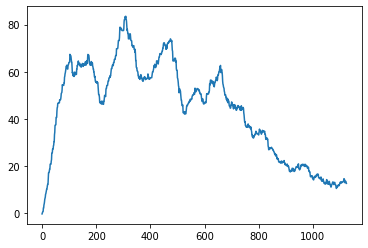

In [4]:
import matplotlib.pyplot as plt
plt.plot(rewards)

In [7]:
trainer.save("./ppo_cp_2")

'./ppo_cp_2/checkpoint_000043/checkpoint-43'

In [5]:

ppo_config = {
    # Should use a critic as a baseline (otherwise don't use value baseline;
    # required for using GAE).
    "use_critic": True,
    # If true, use the Generalized Advantage Estimator (GAE)
    # with a value function, see https://arxiv.org/pdf/1506.02438.pdf.
    "use_gae": True,
    # The GAE (lambda) parameter.
    "lambda": 1.0,
    # Initial coefficient for KL divergence.
    "kl_coeff": 0.2,
    # Size of batches collected from each worker.
    "rollout_fragment_length": 200,
    # Number of timesteps collected for each SGD round. This defines the size
    # of each SGD epoch.
    "train_batch_size": 4000,
    # Total SGD batch size across all devices for SGD. This defines the
    # minibatch size within each epoch.
    "sgd_minibatch_size": 128,
    # Whether to shuffle sequences in the batch when training (recommended).
    "shuffle_sequences": True,
    # Number of SGD iterations in each outer loop (i.e., number of epochs to
    # execute per train batch).
    "num_sgd_iter": 30,
    # Stepsize of SGD.
    "lr": 5e-4,
    # Learning rate schedule.
    "lr_schedule": None,
    # Coefficient of the value function loss. IMPORTANT: you must tune this if
    # you set vf_share_layers=True inside your model's config.
    "vf_loss_coeff": 1.0,
    "model": {
        # Share layers for value function. If you set this to True, it's
        # important to tune vf_loss_coeff.
        "vf_share_layers": False,
    },
    # Coefficient of the entropy regularizer.
    "entropy_coeff": 0.0,
    # Decay schedule for the entropy regularizer.
    "entropy_coeff_schedule": None,
    # PPO clip parameter.
    "clip_param": 0.3,
    # Clip param for the value function. Note that this is sensitive to the
    # scale of the rewards. If your expected V is large, increase this.
    "vf_clip_param": 10.0,
    # If specified, clip the global norm of gradients by this amount.
    "grad_clip": None,
    # Target value for KL divergence.
    "kl_target": 0.01,
    # Whether to rollout "complete_episodes" or "truncate_episodes".
    "batch_mode": "truncate_episodes",
    # Which observation filter to apply to the observation.
    "observation_filter": "NoFilter",

    "num_workers": 10,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [300, 300],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 20,
    "evaluation_config": {
        "render_env": False,
    },
    "num_gpus": 2
}


trainer = ppo.PPOTrainer(env=F110Env, config=ppo_config)
trainer.restore('./ppo_cp_3/checkpoint_000301/checkpoint-301')

2022-02-18 23:04:31,363	WARNING trainer.py:2279 -- You have specified 20 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-02-18 23:04:41,031	WARNING deprecation.py:45 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-02-18 23:04:41,032	WARNING trainer.py:2279 -- You have specified 20 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
(RolloutWorker pid=36342) 2022-02-18 23:04:40,967	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.Remo

In [6]:
trainer.evaluate()

(RolloutWorker pid=36345) 100 [-0.00665975  3.36793743] 0.7571738 0.5946828935352311
(RolloutWorker pid=36331) 100 [0.58733579 3.36074658] 1.0 0.7853981633974483
(RolloutWorker pid=36329) 100 [-0.17309388  3.43364249] -1.0 -0.7853981633974483
(RolloutWorker pid=36356) 100 [0.20880905 3.32590495] 0.16731739 0.13141077115751773
(RolloutWorker pid=36317) 100 [0.12897793 3.37265263] -1.0 -0.7853981633974483
(RolloutWorker pid=36343) 100 [-0.28309587  3.41701267] -0.743107 -0.583634889387227
(RolloutWorker pid=36314) 100 [-0.38523495  3.40529404] -1.0 -0.7853981633974483
(RolloutWorker pid=36335) 100 [0.05015736 3.43712813] -0.24563903 -0.19292444000873546
(RolloutWorker pid=36338) 100 [-0.29816958  3.41262387] -1.0 -0.7853981633974483
(RolloutWorker pid=36347) 100 [0.50703629 3.37932997] -1.0 -0.7853981633974483
(RolloutWorker pid=36345) 200 [-1.74076904  7.81539291] -1.0 -0.7853981633974483
(RolloutWorker pid=36329) 200 [-2.25371249  7.7311532 ] 0.34906983 0.2741588063290169
(RolloutWorke

(RolloutWorker pid=36343) 900 [-32.20196826  21.10266315] -1.0 -0.7853981633974483
(RolloutWorker pid=36345) 1000 [-36.0395972   25.33833418] 1.0 0.7853981633974483
(RolloutWorker pid=36329) 1000 [-35.78746706  25.35161272] 0.027801514 0.021835257777559673
(RolloutWorker pid=36331) 1000 [-35.36557267  24.64840249] 0.41600692 0.3267310730663752
(RolloutWorker pid=36338) 1000 [-36.17164033  24.75695174] 0.94621825 0.7431580774368918
(RolloutWorker pid=36356) 1000 [-35.53490077  24.59613468] 1.0 0.7853981633974483
(RolloutWorker pid=36317) 1000 [-36.16288255  24.76413595] 1.0 0.7853981633974483
(RolloutWorker pid=36314) 1000 [-36.65461788  25.05480513] 0.63906944 0.5019239628734434
(RolloutWorker pid=36335) 1000 [-35.80876408  24.75130325] -0.07241845 -0.056877318654336435
(RolloutWorker pid=36347) 1000 [-35.90418678  25.04164709] -0.8793051 -0.6906046296777051
(RolloutWorker pid=36343) 1000 [-36.06650611  24.27211281] 1.0 0.7853981633974483
(RolloutWorker pid=36345) 1100 [-40.08690608  2

(RolloutWorker pid=36329) 2100 [-47.46996249 -12.46527232] 1.0 0.7853981633974483
(RolloutWorker pid=36314) 2100 [-46.70383259 -13.38502067] 1.0 0.7853981633974483
(RolloutWorker pid=36335) 2100 [-46.71587517 -13.93072135] 1.0 0.7853981633974483
(RolloutWorker pid=36347) 2100 [-47.42191475 -13.30675715] -0.44740903 -0.35139423341457077
(RolloutWorker pid=36317) 2100 [-47.20214975 -12.84083995] 1.0 0.7853981633974483
(RolloutWorker pid=36345) 2200 [-41.95556036 -13.92167203] -1.0 -0.7853981633974483
(RolloutWorker pid=36329) 2200 [-43.33236035 -14.8089307 ] -0.99481213 -0.7813236205563842
(RolloutWorker pid=36335) 2200 [-41.86679718 -13.48533424] -1.0 -0.7853981633974483
(RolloutWorker pid=36314) 2200 [-41.97232699 -13.60560865] -1.0 -0.7853981633974483
(RolloutWorker pid=36347) 2200 [-43.1918163  -14.04544303] -0.2377522 -0.18673014057415782
(RolloutWorker pid=36317) 2200 [-42.55961926 -13.66562583] -0.61344695 -0.4818001085884229
(RolloutWorker pid=36345) 2300 [-37.68680508 -11.495796

(RolloutWorker pid=36329) 4200 [-32.19095725  21.93285459] -1.0 -0.7853981633974483
(RolloutWorker pid=36335) 4200 [-34.04035284  23.41849063] 1.0 0.7853981633974483
(RolloutWorker pid=36347) 4200 [-32.77429627  22.73847717] -0.47689855 -0.3745552460722855
(RolloutWorker pid=36329) 4300 [-36.37118455  24.52386971] 1.0 0.7853981633974483
(RolloutWorker pid=36335) 4300 [-38.35528299  25.67463642] 0.064644694 0.05077182419884263
(RolloutWorker pid=36347) 4300 [-37.00571061  25.31681145] -1.0 -0.7853981633974483
(RolloutWorker pid=36329) 4400 [-40.87988315  24.93970958] 1.0 0.7853981633974483
(RolloutWorker pid=36335) 4400 [-43.10081637  24.43546159] -1.0 -0.7853981633974483
(RolloutWorker pid=36347) 4400 [-41.94309753  25.17457814] 0.7235459 0.5682716280057237
(RolloutWorker pid=36329) 4500 [-45.21056026  22.57553182] 0.95563793 0.7505562765272938
(RolloutWorker pid=36335) 4500 [-47.35344019  21.88026326] -1.0 -0.7853981633974483
(RolloutWorker pid=36347) 4500 [-45.74712983  22.39849018] 

{'evaluation': {'episode_reward_max': 152.0,
  'episode_reward_min': 22.0,
  'episode_reward_mean': 68.8,
  'episode_len_mean': 3045.8,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [29.0,
    35.0,
    28.0,
    73.0,
    109.0,
    124.0,
    57.0,
    59.0,
    22.0,
    152.0],
   'episode_lengths': [1376,
    1599,
    1356,
    3199,
    4779,
    5443,
    2532,
    2600,
    1043,
    6531]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.09879980384419466,
   'mean_inference_ms': 0.9937557777204805,
   'mean_action_processing_ms': 0.08389772307414425,
   'mean_env_wait_ms': 8.972713141420993,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

In [15]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = trainer.compute_action(obs)
    print(action)
    obs, reward, done, _ = env.step(action)
    
#     env.render()
    


2022-02-18 02:19:50,127	WARNING deprecation.py:45 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


[ 1.        -0.9999935]
[ 1.        -0.9999993]
[ 1. -1.]
[ 1.        -0.9999743]
[ 1.        -0.9999539]
[ 1.        -0.9999715]
[ 1.       -0.999969]
[ 1.        -0.9999741]
[ 1.         -0.99997634]
[ 1.         -0.99994713]
[ 1.         -0.99996305]
[ 1.         -0.99995804]
[ 1.       -0.999936]
[ 1.       -0.999926]
[ 1.        -0.9999143]
[ 1.         -0.99996144]
[ 0.99999523 -0.9999549 ]
[ 1.         -0.99996966]
[ 1.        -0.9999777]
[ 1.        -0.9999709]
[ 1.         -0.99996626]
[ 1.         -0.99995756]
[ 1.        -0.9999833]
[ 0.99999976 -1.        ]
[ 0.99996984 -0.99997646]
[ 0.99996537 -1.        ]
[ 0.9999637  -0.99999875]
[ 0.9999587 -0.9999771]
[ 0.9999717  -0.99996775]
[ 0.99998355 -0.9999801 ]
[ 0.9999743 -0.9999579]
[ 0.99997175 -0.9999657 ]
[ 0.9999882 -0.9999674]
[ 0.9999686 -0.9999867]
[ 0.9999765 -0.9999889]
[ 0.9999317 -0.9999943]
[ 0.9999337 -1.       ]
[ 0.9999138 -1.       ]
[ 0.9999244  -0.99999744]
[ 0.99993867 -1.        ]
[ 0.99991655 -1.        

[ 0.9999598 -1.       ]
[ 0.9999628 -1.       ]
[ 0.99994475 -1.        ]
[ 0.9999653 -1.       ]
[ 0.99995637 -1.        ]
[ 0.99996954 -1.        ]
[ 0.9999693 -1.       ]
[ 0.9999883 -1.       ]
[ 0.99997413 -1.        ]
[ 0.99998116 -1.        ]
[ 0.99998796 -1.        ]
[ 1. -1.]
[ 1. -1.]
[ 0.9999908 -1.       ]
[ 1. -1.]
[ 0.99999046 -1.        ]
[ 0.9999991 -1.       ]
[ 0.9999872 -0.9999709]
[ 0.9999914  -0.99995875]
[ 0.99997187 -0.99998176]
[ 0.99997085 -0.9999865 ]
[ 0.99997133 -1.        ]
[ 1.      -0.99999]
[ 1. -1.]
[ 1. -1.]
[ 0.9999957 -0.9999828]
[ 0.9999653 -0.9999563]
[ 0.99995965 -0.99995756]
[ 0.9999508 -0.9999585]
[ 0.999959  -0.9999652]
[ 0.99994195 -0.9999842 ]
[ 0.99996144 -0.9999634 ]
[ 0.99995404 -0.9999661 ]
[ 0.99998015 -0.9999431 ]
[ 0.9999793  -0.99994195]
[ 0.99998915 -0.99994546]
[ 0.99997544 -0.99995387]
[ 0.9999667  -0.99996334]
[ 0.9999582 -0.9999607]
[ 0.9999617  -0.99997497]
[ 0.99995375 -0.9999853 ]
[ 0.99996066 -0.9999804 ]
[ 0.9999743 -0.99997

[ 1. -1.]
[ 1.        -0.9999947]
[ 1.        -0.9999953]
[ 1.        -0.9999916]
[ 1.        -0.9999793]
[ 1. -1.]
[ 1.         -0.99997795]
[ 1. -1.]
[ 1. -1.]
[ 1.         -0.99997735]
[ 1.       -0.999962]
[ 1.         -0.99996185]
[ 1.        -0.9999729]
[ 1.         -0.99999267]
[ 1.        -0.9999828]
[ 0.9999814 -0.9999837]
[ 0.99998647 -0.99999046]
[ 0.9999791 -0.9999931]
[ 0.9999682 -1.       ]
[ 0.99997884 -1.        ]
[ 0.99996656 -1.        ]
[ 0.9999689 -1.       ]
[ 0.99999243 -1.        ]
[ 1. -1.]
[ 0.9999863 -1.       ]
[ 0.99999726 -1.        ]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1.        -0.9999907]
[ 1.        -0.9999636]
[ 1.        -0.9999277]
[ 1.        -0.9999558]
[ 1.       -0.999944]
[ 0.9999999 -0.9999601]
[ 0.9999975 -0.999938 ]
[ 0.9999731 -0.999944 ]
[ 0.9999864  -0.99993825]
[ 0.9999705 -0.9999243]
[ 0.99999356 -0.999933  ]
[ 0.99998283 -0.99994797]
[ 0.99995625 -0.9999671 ]
[ 0.9999788 -0.9999937]
[ 0.99996114 -0.9999792 ]
[ 0.9999575 

[ 1.       -0.999959]
[ 1.        -0.9999359]
[ 1.         -0.99992156]
[ 1.        -0.9999397]
[ 0.9999838  -0.99992657]
[ 0.9999758 -0.999916 ]
[ 0.9999839 -0.9999357]
[ 0.9999832 -0.9999135]
[ 0.9999995 -0.9999116]
[ 1.         -0.99991983]
[ 1.      -0.99993]
[ 1.        -0.9999389]
[ 1.        -0.9999417]
[ 1.         -0.99996036]
[ 0.99998915 -0.99996537]
[ 0.99998087 -0.99997216]
[ 0.9999499  -0.99997014]
[ 0.99996614 -0.9999848 ]
[ 0.99997157 -0.9999767 ]
[ 1.         -0.99997056]
[ 1.         -0.99997336]
[ 1.        -0.9999759]
[ 0.9999899  -0.99998647]
[ 1.        -0.9999724]
[ 1.         -0.99996364]
[ 1.        -0.9999657]
[ 0.99998784 -0.9999662 ]
[ 0.99999046 -0.99999243]
[ 1.        -0.9999932]
[ 1.        -0.9999778]
[ 1.        -0.9999999]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1.         -0.99998266]
[ 1.         -0.99997973]
[ 1.        -0.9999741]
[ 1.       -0.999974]
[ 1.         -0.99999255]
[ 1.         -0.99999106]
[ 1.         -0.99999535]
[ 1.        -0.9

[ 1. -1.]
[ 0.9999885 -1.       ]
[ 0.9999775 -1.       ]
[ 0.9999869 -1.       ]
[ 0.99995583 -1.        ]
[ 0.99997145 -0.99999595]
[ 0.99997985 -0.9999802 ]
[ 0.999967   -0.99996096]
[ 0.99996716 -0.9999862 ]
[ 0.99999547 -0.9999877 ]
[ 1.        -0.9999877]
[ 1.        -0.9999914]
[ 1.        -0.9999784]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 0.9999994 -1.       ]
[ 0.9999726 -1.       ]
[ 0.9999591 -1.       ]
[ 0.9999597 -1.       ]
[ 0.999987  -0.9999838]
[ 0.9999751 -1.       ]
[ 1. -1.]
[ 1.        -0.9999923]
[ 1.         -0.99999505]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1.         -0.99999756]
[ 1.        -0.9999739]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1.        -0.9999765]
[ 0.9999912 -0.9999572]
[ 0.9999661 -0.9999388]
[ 0.9999329  -0.99993575]
[ 0.99991584 -0.99992925]
[ 0.99994063 -0.99991864]
[ 0.99996156 -0.9999438 ]
[ 0.9999711 -0.9999677]
[ 0.9999537  -0.99996847]
[ 0.9999679  -0.99996156]
[ 0.99998605 -0.99997646]
[ 0.9999

[ 0.99999774 -0.99996084]
[ 1.        -0.9999551]
[ 1.        -0.9999866]
[ 1. -1.]
[ 1. -1.]
[ 1.         -0.99998754]
[ 1.         -0.99999475]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1.       -0.999996]
[ 1.        -0.9999936]
[ 1.        -0.9999858]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 0.99999267 -1.        ]
[ 0.9999822 -0.9999971]
[ 0.9999924 -0.999958 ]
[ 1.        -0.9999776]
[ 1.        -0.9999926]
[ 1. -1.]
[ 1.         -0.99998945]
[ 0.9999936 -0.9999941]
[ 0.9999802 -1.       ]
[ 0.9999718 -0.9999847]
[ 0.9999606  -0.99998975]
[ 0.99996 -1.     ]
[ 0.99998665 -0.9999927 ]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 0.99999183 -1.        ]
[ 0.99998975 -1.        ]
[ 1.        -0.9999788]
[ 0.99999815 -0.99997896]
[ 0.9999913 -0.9999814]
[ 0.99996835 -0.9999868 ]
[ 0.9999737 -0.9999779]
[ 0.9999808 -0.9999832]
[ 0.9999997  -0.99995196]
[ 1.         -0.99996066]
[ 0.9999914  -0.99996763]
[ 0.9999797  -0.99995184

[ 0.99998    -0.99997973]
[ 0.9999845 -0.99999  ]
[ 0.9999658 -0.9999788]
[ 0.99999994 -0.9999956 ]
[ 1. -1.]
[ 0.99998283 -1.        ]
[ 0.9999713  -0.99999774]
[ 0.99994934 -0.9999943 ]
[ 0.9999623 -1.       ]
[ 0.9999488 -1.       ]
[ 0.9999592 -1.       ]
[ 0.9999856 -0.9999982]
[ 0.9999999 -0.999993 ]
[ 1. -1.]
[ 1. -1.]
[ 1.        -0.9999962]
[ 1.        -0.9999982]
[ 1.        -0.9999911]
[ 1.         -0.99998367]
[ 1.        -0.9999746]
[ 1.         -0.99998546]
[ 1.         -0.99997675]
[ 1.        -0.9999784]
[ 0.9999938  -0.99998385]
[ 0.99997157 -0.9999687 ]
[ 0.9999596 -0.9999903]
[ 0.99997336 -0.9999947 ]
[ 0.99995166 -1.        ]
[ 0.9999704  -0.99998707]
[ 0.9999546 -0.9999608]
[ 0.99995047 -0.99993414]
[ 0.999948  -0.9999941]
[ 0.99993885 -0.99997836]
[ 0.9999484 -1.       ]
[ 0.9999465 -1.       ]
[ 0.9999509  -0.99998164]
[ 0.99993944 -1.        ]
[ 0.9999561 -1.       ]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 0.9999791  -0.99998415]
[ 0.99997866 -1.        ]
[ 0.9999749 -0

[ 1. -1.]
[ 1.        -0.9999889]
[ 1.        -0.9999974]
[ 1. -1.]
[ 1. -1.]
[ 0.9999897 -1.       ]
[ 0.9999635 -1.       ]
[ 0.9999643 -1.       ]
[ 0.99998575 -1.        ]
[ 0.99999124 -1.        ]
[ 0.99999267 -1.        ]
[ 0.9999674 -1.       ]
[ 0.9999881 -0.9999965]
[ 1.        -0.9999964]
[ 0.9999944  -0.99999636]
[ 0.9999857 -0.99999  ]
[ 0.99996287 -0.9999861 ]
[ 0.99996346 -0.9999545 ]
[ 0.9999814  -0.99996465]
[ 0.9999788 -0.9999615]
[ 0.9999649 -0.9999659]
[ 0.99999136 -0.9999762 ]
[ 0.9999793  -0.99998194]
[ 0.9999717 -0.9999802]
[ 0.99993753 -0.9999962 ]
[ 0.9999189 -0.9999918]
[ 0.99994683 -0.9999931 ]
[ 0.9999465 -1.       ]
[ 0.9999595 -1.       ]
[ 0.999981 -1.      ]
[ 0.9999775 -1.       ]
[ 0.9999976 -1.       ]
[ 0.99998575 -1.        ]
[ 0.9999923 -1.       ]
[ 0.9999851 -1.       ]
[ 1.        -0.9999961]
[ 1.        -0.9999708]
[ 0.99999064 -0.99998146]
[ 1.         -0.99999917]
[ 1. -1.]
[ 1.         -0.99999374]
[ 1. -1.]
[ 1.        -0.9999878]
[ 1. -1.]


KeyboardInterrupt: 

## discrete action

### define environment

In [3]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.action_space = gym.spaces.Discrete(8,)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        
        self.action_map = {
            0: [0., 0.],
            1: [0., 5.],
            2: [-np.pi/4, 5.],
            3: [np.pi/4, 5],
            4: [-np.pi/6, 5.],
            5: [np.pi/6, 5],
            6: [-np.pi/4, 2.5], #later
            7: [np.pi/4, 2.5] #later
        }

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs]
        self.t = 0
        
        
        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.next_cp_idx = 2
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        buck = 3
        scanner = np.zeros(1080//buck,)
        for i in range(1080//buck):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        scanner /= 10
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
            np.array(obs['ang_vels_z'][:1])/2
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
#             print(f"Got to CP {self.next_cp_idx}")
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        act = np.array([self.action_map[action]])
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -1
            
#         if int(self.t+1) % 100 == 0:
#             print(action)
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

### training

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG
ppo_config = {
    # Should use a critic as a baseline (otherwise don't use value baseline;
    # required for using GAE).
    "use_critic": True,
    # If true, use the Generalized Advantage Estimator (GAE)
    # with a value function, see https://arxiv.org/pdf/1506.02438.pdf.
    "use_gae": True,
    # The GAE (lambda) parameter.
    "lambda": 1.0,
    # Initial coefficient for KL divergence.
    "kl_coeff": 0.2,
    # Size of batches collected from each worker.
    "rollout_fragment_length": 200,
    # Number of timesteps collected for each SGD round. This defines the size
    # of each SGD epoch.
    "train_batch_size": 4000,
    # Total SGD batch size across all devices for SGD. This defines the
    # minibatch size within each epoch.
    "sgd_minibatch_size": 128,
    # Whether to shuffle sequences in the batch when training (recommended).
    "shuffle_sequences": True,
    # Number of SGD iterations in each outer loop (i.e., number of epochs to
    # execute per train batch).
    "num_sgd_iter": 30,
    # Stepsize of SGD.
    "lr": 5e-4,
    # Learning rate schedule.
    "lr_schedule": None,
    # Coefficient of the value function loss. IMPORTANT: you must tune this if
    # you set vf_share_layers=True inside your model's config.
    "vf_loss_coeff": 1.0,
    "model": {
        # Share layers for value function. If you set this to True, it's
        # important to tune vf_loss_coeff.
        "vf_share_layers": False,
    },
    # Coefficient of the entropy regularizer.
    "entropy_coeff": 0.0,
    # Decay schedule for the entropy regularizer.
    "entropy_coeff_schedule": None,
    # PPO clip parameter.
    "clip_param": 0.3,
    # Clip param for the value function. Note that this is sensitive to the
    # scale of the rewards. If your expected V is large, increase this.
    "vf_clip_param": 10.0,
    # If specified, clip the global norm of gradients by this amount.
    "grad_clip": None,
    # Target value for KL divergence.
    "kl_target": 0.01,
    # Whether to rollout "complete_episodes" or "truncate_episodes".
    "batch_mode": "truncate_episodes",
    # Which observation filter to apply to the observation.
    "observation_filter": "NoFilter",

    "num_workers": 10,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [300, 300],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 20,
    "evaluation_config": {
        "render_env": False,
    },
    "num_gpus": 2
}

dqn_config = {
    # === Model ===
    # Number of atoms for representing the distribution of return. When
    # this is greater than 1, distributional Q-learning is used.
    # the discrete supports are bounded by v_min and v_max
    "num_atoms": 1,
    "v_min": -10.0,
    "v_max": 10.0,
    # Whether to use noisy network
    "noisy": False,
    # control the initial value of noisy nets
    "sigma0": 0.5,
    # Whether to use dueling dqn
    "dueling": True,
    # Dense-layer setup for each the advantage branch and the value branch
    # in a dueling architecture.
    "hiddens": [300, 300],
    # Whether to use double dqn
    "double_q": True,
    # N-step Q learning
    "n_step": 1,
    "lr": 0.0001,
    # === Prioritized replay buffer ===
    # If True prioritized replay buffer will be used.
    "prioritized_replay": True,
    # Alpha parameter for prioritized replay buffer.
    "prioritized_replay_alpha": 0.6,
    # Beta parameter for sampling from prioritized replay buffer.
    "prioritized_replay_beta": 0.4,
    # Final value of beta (by default, we use constant beta=0.4).
    "final_prioritized_replay_beta": 0.4,
    # Time steps over which the beta parameter is annealed.
    "prioritized_replay_beta_annealing_timesteps": 20000,
    # Epsilon to add to the TD errors when updating priorities.
    "prioritized_replay_eps": 1e-6,

    "replay_buffer_config": {
        "type": "MultiAgentReplayBuffer",
        "capacity": int(1e5),
    },
    "exploration_config": {
        # The Exploration class to use. In the simplest case, this is the name
        # (str) of any class present in the `rllib.utils.exploration` package.
        # You can also provide the python class directly or the full location
        # of your class (e.g. "ray.rllib.utils.exploration.epsilon_greedy.
        # EpsilonGreedy").
        "type": "EpsilonGreedy",
        "initial_epsilon" : 1.0,
        "final_epsilon": 0.05,
        "epsilon_timesteps": int(1e9),
        # Add constructor kwargs here (if any).
    },
#         "num_workers": 10,
    "framework": "torch",

    "evaluation_num_workers": 20,
    "evaluation_config": {
        "render_env": False,
    },
    "num_gpus": 2
}

ray.shutdown()
ray.init()
# trainer = ppo.PPOTrainer(env=F110Env, config=ppo_config)
# trainer = sac.SACTrainer(env=F110Env, config=sac_configs)
# trainer = ddpg.DDPGTrainer(env=F110Env, config=ddpg_configs)
APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 1
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e7)


trainer = dqn.ApexTrainer(env=F110Env, config=APEX_DEFAULT_CONFIG)
rewards = []

for i in range(10000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%10 == 0:
        cp = trainer.save("./dqn_cp")
        print("checkpoint saved at", cp)


(RolloutWorker pid=11349) 2022-02-19 17:48:34,157	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=11311) 2022-02-19 17:48:34,160	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=11315) 2022-02-19 17:48:34,170	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=11300) 2022-02-19 17:48:34,164	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.Remo

2022-02-19 17:48:37,154	INFO trainable.py:125 -- Trainable.setup took 19.368 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-02-19 17:48:37,156	WARNING util.py:55 -- Install gputil for GPU system monitoring.
(MultiAgentReplayBuffer pid=11312) 2022-02-19 17:48:37,875	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4725 GB (500000.0 batches of size 1, 2945 bytes each), available system memory is 540.168687616 GB
(MultiAgentReplayBuffer pid=11308) 2022-02-19 17:48:37,900	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4725 GB (500000.0 batches of size 1, 2945 bytes each), available system memory is 540.168687616 GB
(MultiAgentReplayBuffer pid=11328) 2022-02-19 17:48:37,938	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4725 GB (500000.0 batches of size 1, 2945 bytes each), available system memory is 540.168687616 GB
(Multi

episode: 0 reward:-1.0
checkpoint saved at ./dqn_cp/checkpoint_000001/checkpoint-1
episode: 1 reward:-0.7045454545454546
episode: 2 reward:0.21019108280254778
episode: 3 reward:-0.018518518518518517
episode: 4 reward:0.26143790849673204
episode: 5 reward:0.6405228758169934
episode: 6 reward:0.14720812182741116
episode: 7 reward:0.7553956834532374
episode: 8 reward:2.08
episode: 9 reward:3.95
episode: 10 reward:4.88
checkpoint saved at ./dqn_cp/checkpoint_000011/checkpoint-11
episode: 11 reward:8.31
episode: 12 reward:10.34
episode: 13 reward:14.67
episode: 14 reward:18.55
episode: 15 reward:20.5
episode: 16 reward:22.97
episode: 17 reward:25.15
episode: 18 reward:26.83
episode: 19 reward:27.35
episode: 20 reward:30.9
checkpoint saved at ./dqn_cp/checkpoint_000021/checkpoint-21
episode: 21 reward:31.55
episode: 22 reward:33.45
episode: 23 reward:34.22
episode: 24 reward:37.0
episode: 25 reward:37.99
episode: 26 reward:39.12
episode: 27 reward:42.32
episode: 28 reward:45.52
episode: 29 r

In [7]:
APEX_DEFAULT_CONFIG

{'num_workers': 32,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 50,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 0.0005,
 'train_batch_size': 512,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,


(RolloutWorker pid=1477) 2022-02-19 17:34:53,395	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1486) 2022-02-19 17:34:53,556	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1506) 2022-02-19 17:34:53,728	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1480) 2022-02-19 17:34:53,666	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBa